# Cis Regulation Analysis

In [413]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [414]:
### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.display import Image, display
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy
import scipy.stats
import sklearn
from sklearn import preprocessing
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from matplotlib_venn import venn3, venn2
import pickle
from matplotlib import patches as mpatches
from sklearn.cluster import KMeans
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn import ensemble
from sklearn import neighbors
import networkx as nx
import matplotlib_venn
from sklearn.cross_validation import train_test_split
from random import shuffle
%matplotlib inline
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
sns.set_context('notebook')

## Functions

In [415]:

def get_matched_split(features, labels, test_size):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    '''
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
    
        
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]


    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    return training_features, test_features, training_labels, test_labels
    

## Preprocessing

In [416]:
# file directories
workingDirectory = '/home/jenhan/analysis/cis_regulation_analysis/'

genomes = ['hg19','mm10', 'hg38']
scratchDirectory = workingDirectory + '/scratch/'


### RNA-seq

In [10]:

tagDirPath = workingDirectory + '/tag_directories_rna/'


os.chdir(workingDirectory)

strains = []
treatments = []
owners = []
dates = []
originalNames = []
cellTypes = []
for f in os.listdir(tagDirPath):
    originalName = f
    metaDataTokens = f.split('_')
    
    originalNames.append(originalName)
    # grab metadata from string tokens
    strain = metaDataTokens[0].strip()
    cellType = metaDataTokens[1].strip()
    treatment = metaDataTokens[3].strip().split('-')[0]
    owner = metaDataTokens[5].strip()
    date = metaDataTokens[4].strip()
    
    # append to overall lists
    strains.append(strain)
    treatments.append(treatment)
    owners.append(owner)
    dates.append(date)
    cellTypes.append(cellType)
metadata_frame = pd.DataFrame([strains, 
                                  cellTypes,
                                  treatments, 
                                  owners, 
                                  originalNames, 
                                  ]).transpose()
metadata_frame.columns = ['strain', 
                          'Cell Type',
                         'treatment',
                         'owner', 
                         'sampleName']

# ### read in log files ###

# create data frame summarizing mapping quality logs

# from tagInfo.txt
_originalNames =[]
_totalReads = []
_fragmentLengthEstimate =[]
_peakSizeEstimate = []
_tagsPerBP = []
_averageTagsPerPosition = []
_averageTagLength = []
_averageFragmentGCcontent = []


for tagdir in os.listdir(tagDirPath):
    with open(tagDirPath + '/' + tagdir + '/tagInfo.txt') as f:
        data = f.readlines()
        _originalNames.append(tagdir)
        _fragmentLengthEstimate.append(float(data[2].strip().split('=')[1]))
        _peakSizeEstimate.append(float(data[3].strip().split('=')[1]))
        _tagsPerBP.append(float(data[4].strip().split('=')[1]))
        _averageTagsPerPosition.append(float(data[5].strip().split('=')[1]))
        _averageTagLength.append(float(data[6].strip().split('=')[1]))
        _averageFragmentGCcontent.append(float(data[8].strip().split('=')[1]))
        _totalReads.append(float(data[1].split()[2]))
mappingStats_frame = pd.DataFrame([_originalNames,
                                   _totalReads, 

                                   _fragmentLengthEstimate,
                                   _peakSizeEstimate,
                                   _tagsPerBP,
                                   _averageTagsPerPosition,
                                   _averageTagLength,
                                   _averageFragmentGCcontent,
                                  ]).transpose()
mappingStats_frame.columns = ['sampleName',
                              'totalReads', 
                              'fragmentLengthEstimate',
                              'peakSizeEstimate',
                              'tagsPerBP',
                              'averageTagsPerPosition',
                              'averageTagLength',
                              'averageFragmentGCcontent']

summary_frame = metadata_frame.merge(mappingStats_frame, on='sampleName')


summary_frame.index  = pd.MultiIndex.from_arrays([list(summary_frame['strain'].values), list(summary_frame['Cell Type'].values)])
summary_frame = summary_frame.sort()
summary_frame.to_csv('qc_metrics_rna.tsv', sep='\t', index=False)
summary_frame_rna = summary_frame.copy()

### ATAC-seq

In [417]:

tagDirPath = workingDirectory + '/tag_directories_atac/'

strains = []
treatments = []
owners = []
dates = []
originalNames = []
cellTypes = []
for f in os.listdir(tagDirPath):
    originalName = f
    metaDataTokens = f.split('_')
    
    originalNames.append(originalName)
    # grab metadata from string tokens
    strain = metaDataTokens[0].strip()
    cellType = metaDataTokens[1].strip()
    treatment = metaDataTokens[3].strip().split('-')[0]
    owner = metaDataTokens[5].strip()
    date = metaDataTokens[4].strip()
    
    # append to overall lists
    strains.append(strain)
    treatments.append(treatment)
    owners.append(owner)
    dates.append(date)
    cellTypes.append(cellType)
metadata_frame = pd.DataFrame([strains, 
                                  cellTypes,
                                  treatments, 
                                  owners, 
                                  originalNames, 
                                  ]).transpose()
metadata_frame.columns = ['strain', 
                          'Cell Type',
                         'treatment',
                         'owner', 
                         'sampleName']

# ### read in log files ###

# create data frame summarizing mapping quality logs

# from tagInfo.txt
_originalNames =[]
_totalReads = []
_fragmentLengthEstimate =[]
_peakSizeEstimate = []
_tagsPerBP = []
_averageTagsPerPosition = []
_averageTagLength = []
_averageFragmentGCcontent = []


for tagdir in os.listdir(tagDirPath):
    with open(tagDirPath + '/' + tagdir + '/tagInfo.txt') as f:
        data = f.readlines()
        _originalNames.append(tagdir)
        _fragmentLengthEstimate.append(float(data[2].strip().split('=')[1]))
        _peakSizeEstimate.append(float(data[3].strip().split('=')[1]))
        _tagsPerBP.append(float(data[4].strip().split('=')[1]))
        _averageTagsPerPosition.append(float(data[5].strip().split('=')[1]))
        _averageTagLength.append(float(data[6].strip().split('=')[1]))
        _averageFragmentGCcontent.append(float(data[8].strip().split('=')[1]))
        _totalReads.append(float(data[1].split()[2]))
mappingStats_frame = pd.DataFrame([_originalNames,
                                   _totalReads, 

                                   _fragmentLengthEstimate,
                                   _peakSizeEstimate,
                                   _tagsPerBP,
                                   _averageTagsPerPosition,
                                   _averageTagLength,
                                   _averageFragmentGCcontent,
                                  ]).transpose()
mappingStats_frame.columns = ['sampleName',
                              'totalReads', 
                              'fragmentLengthEstimate',
                              'peakSizeEstimate',
                              'tagsPerBP',
                              'averageTagsPerPosition',
                              'averageTagLength',
                              'averageFragmentGCcontent']

summary_frame = metadata_frame.merge(mappingStats_frame, on='sampleName')


summary_frame.index  = pd.MultiIndex.from_arrays([list(summary_frame['strain'].values), 
                                                  list(summary_frame['Cell Type'].values), 
                                                  list(summary_frame['treatment'].values)])
summary_frame = summary_frame.sort()
summary_frame.to_csv('qc_metrics_atac.tsv', sep='\t', index=False)
summary_frame_atac = summary_frame.copy()

## Filter Data on QC Metrics

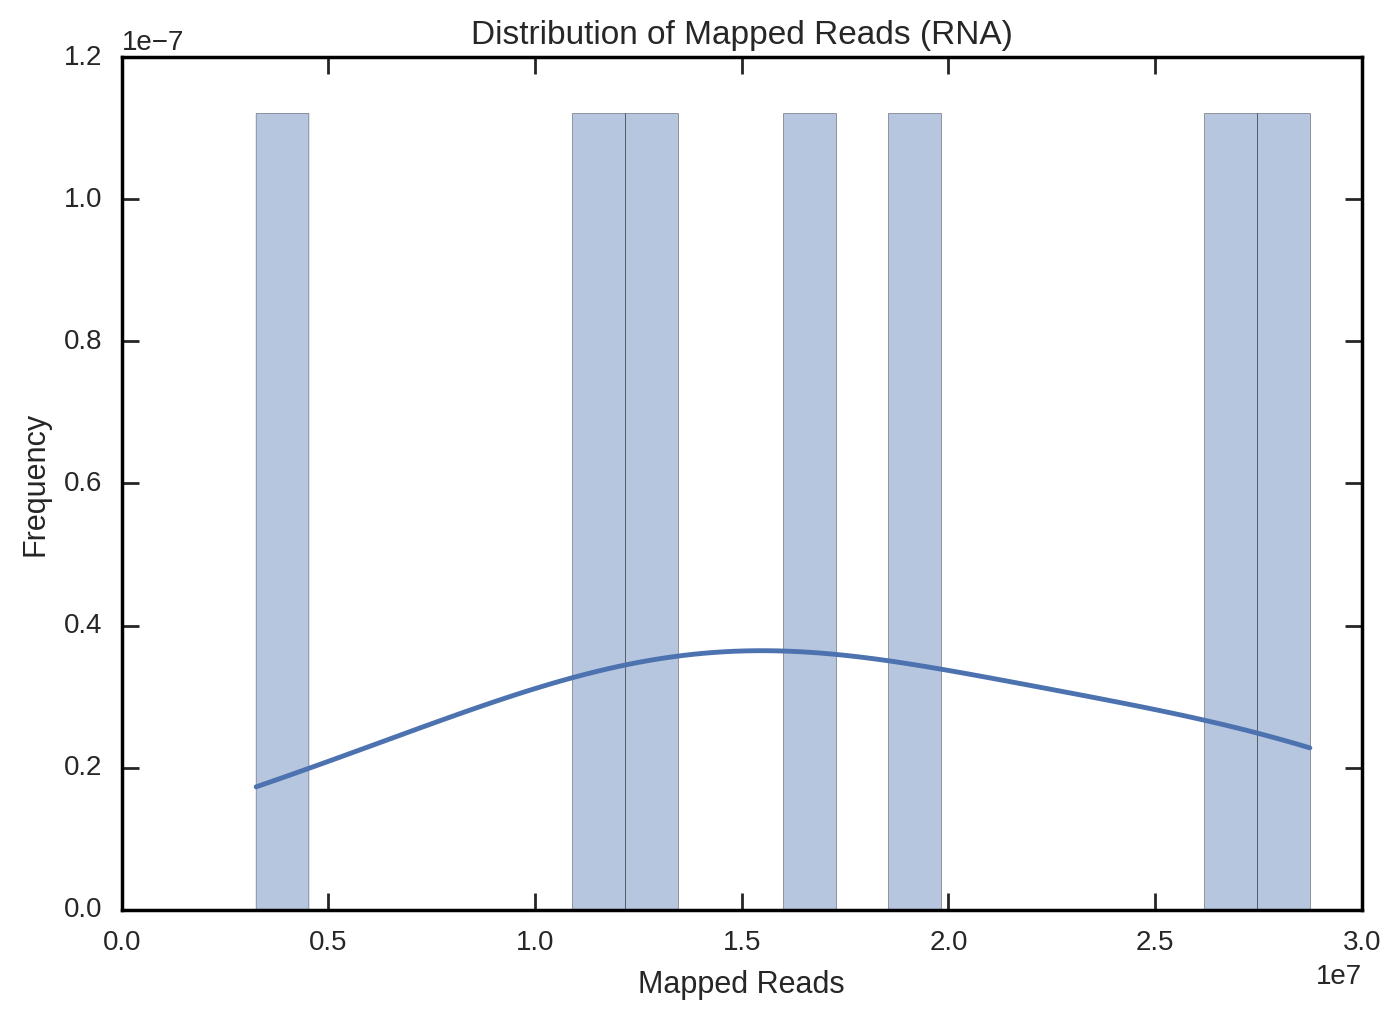

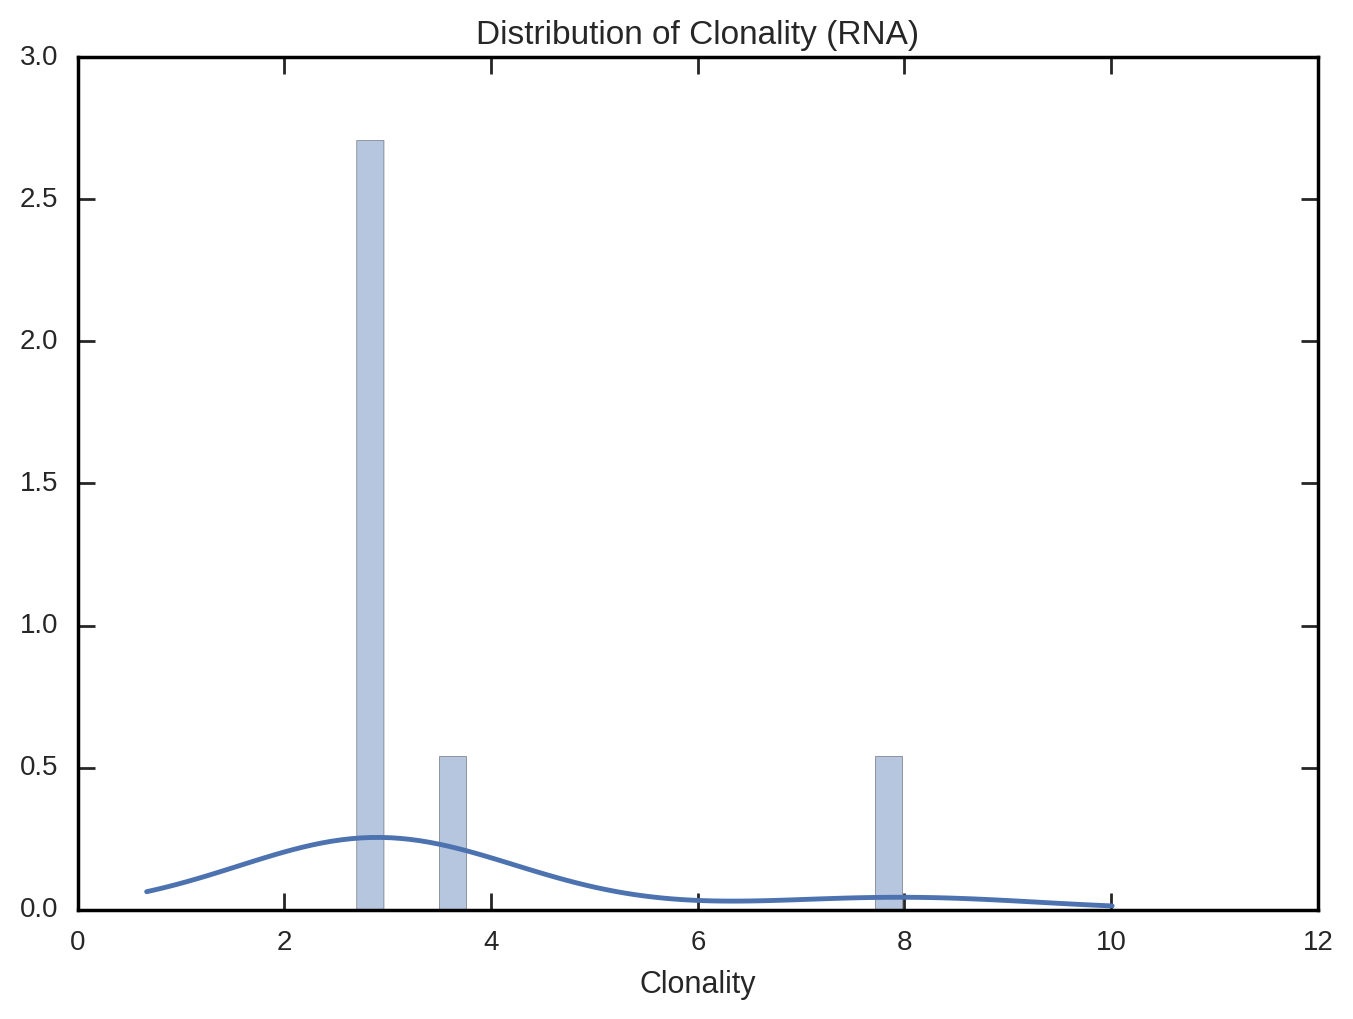

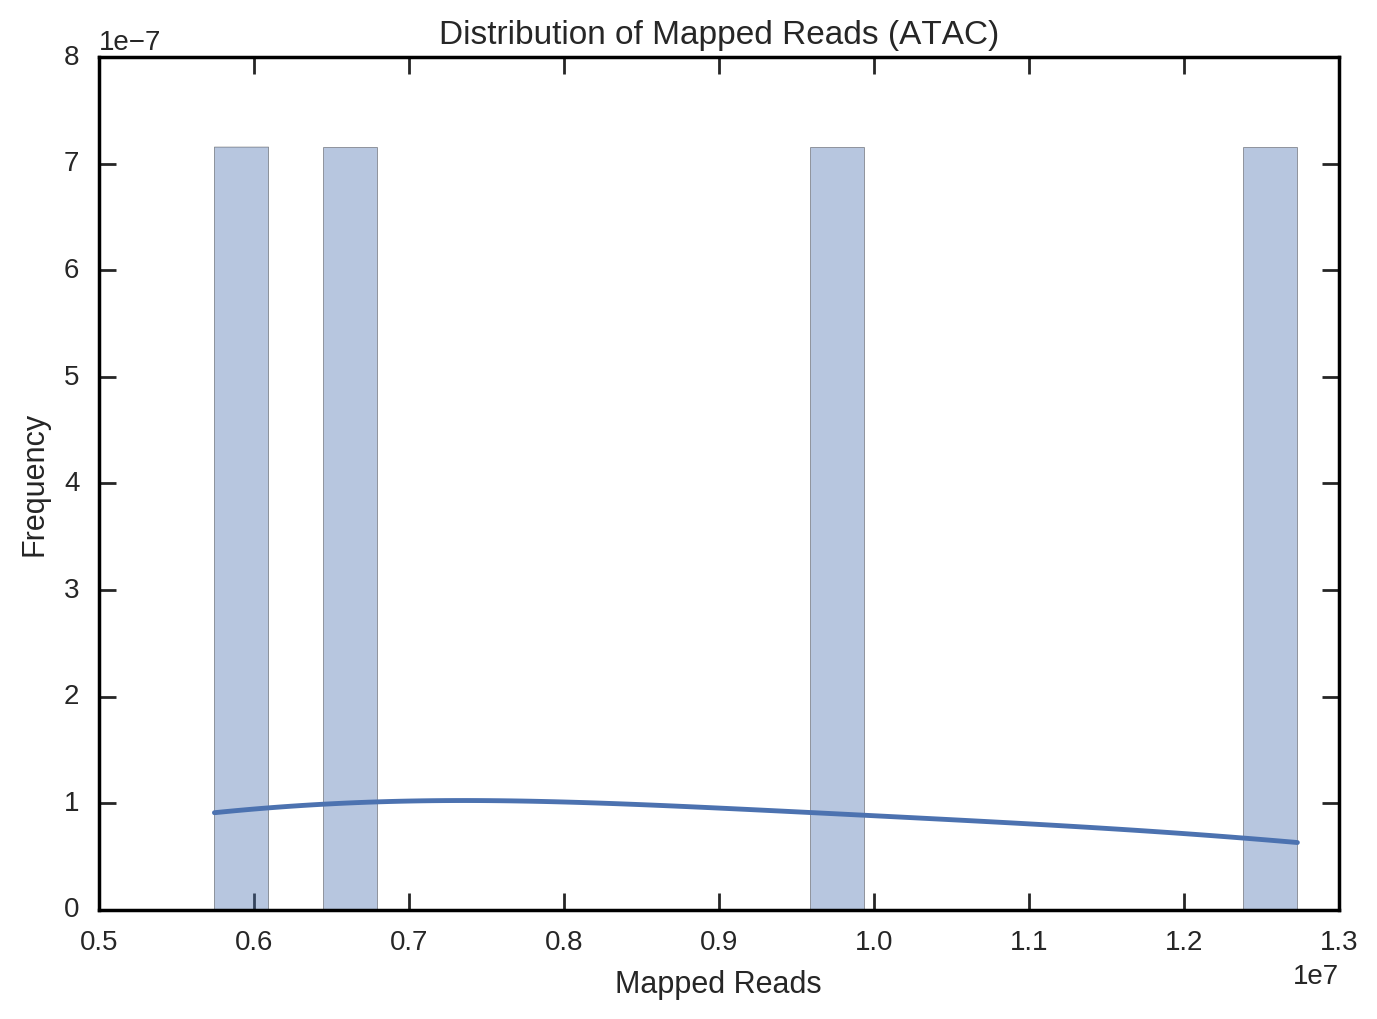

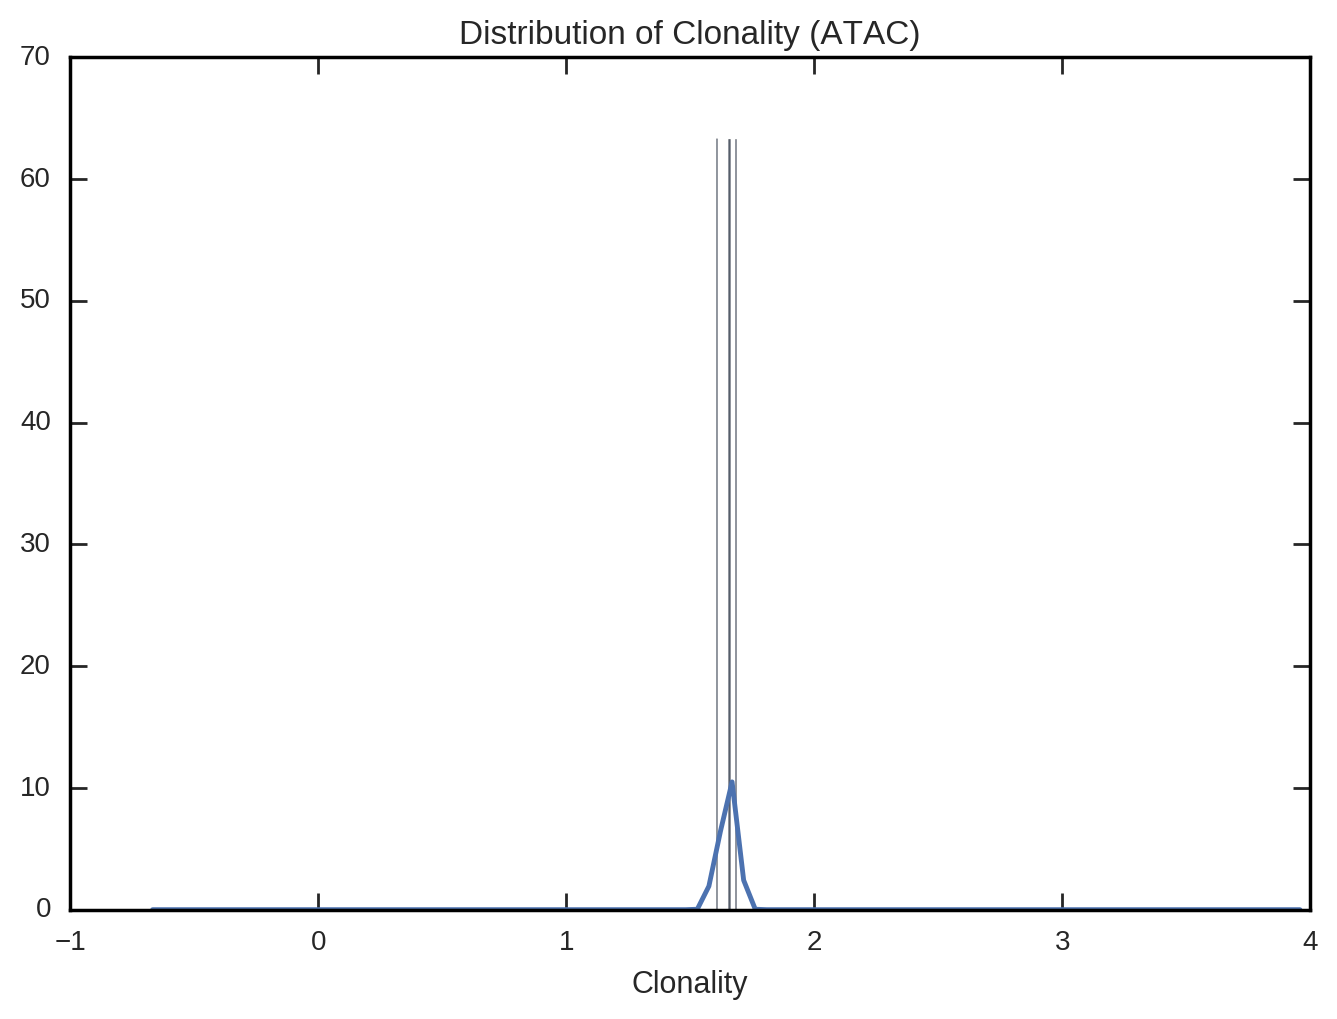

In [418]:
sns.distplot(summary_frame_rna['totalReads'], bins=20, kde=True)
plt.title('Distribution of Mapped Reads (RNA)')
plt.xlabel('Mapped Reads')
plt.ylabel('Frequency')
plt.show()

sns.distplot(summary_frame_rna['averageTagsPerPosition'], bins=20)
plt.title('Distribution of Clonality (RNA)')
plt.xlabel('Clonality')
plt.show()

sns.distplot(summary_frame_atac['totalReads'], bins=20, kde=True)
plt.title('Distribution of Mapped Reads (ATAC)')
plt.xlabel('Mapped Reads')
plt.ylabel('Frequency')
plt.show()

sns.distplot(summary_frame_atac['averageTagsPerPosition'], bins=20)
plt.title('Distribution of Clonality (ATAC)')
plt.xlabel('Clonality')
plt.show()


In [419]:
filtered_summary_frame_atac = summary_frame_atac.copy()

In [420]:
# filter samples according to threshold for the fraction of uniquely mapped reads
readsThreshold = 1000000
pbcThreshold=0.0
# gcThreshold=0.10
clonalityThreshold = 20
# spotThreshold = 0.005

filtered_summary_frame_rna = summary_frame_rna.copy()

filtered_summary_frame_rna = filtered_summary_frame_rna[filtered_summary_frame_rna['totalReads'] >= readsThreshold]

filtered_summary_frame_rna = filtered_summary_frame_rna[filtered_summary_frame_rna['averageTagsPerPosition'] <= clonalityThreshold]

## Calculate RPKM Values

In [16]:
filteredTagDirectories = ' '.join(['/home/jenhan/analysis/cis_regulation_analysis/tag_directories_rna/' +x for x in filtered_summary_frame_rna['sampleName']])
!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d $filteredTagDirectories > rpkm.tsv
!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -noadj -d $filteredTagDirectories > raw.tsv



	Tag Directories:
		/home/jenhan/analysis/cis_regulation_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_GFEW_16-02-04
		/home/jenhan/analysis/cis_regulation_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_CR_12-03-09
		/home/jenhan/analysis/cis_regulation_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_VML_15-02-26
		/home/jenhan/analysis/cis_regulation_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-1h_VML_15-02-26
		/home/jenhan/analysis/cis_regulation_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-1h_CR_12-03-09
		/home/jenhan/analysis/cis_regulation_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_TKS_15-04-06
		/home/jenhan/analysis/cis_regulation_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_TKS_14-12-15
	Input file format: homerRmsk
	Filtering based on repeat parameters: kept 35756 of 35756
	Calculating read coverage for /home/jenhan/analysis/cis_regulation_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_GFEW_16-02-04
	Calculating read coverage

In [658]:
# read in RPKM values
rpkm_frame = pd.read_csv("rpkm.tsv",sep="\t")
columns = rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
rpkm_frame.columns = columns    
rpkm_frame['gene'] = [x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']]
columns = list(rpkm_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
rpkm_frame = rpkm_frame[columns]


raw_frame = pd.read_csv("raw.tsv",sep="\t")
columns = raw_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "/home" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
raw_frame.columns = columns  
raw_frame['gene'] = [x.split("|")[0] for x in raw_frame['Annotation/Divergence']]
columns = list(raw_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
raw_frame = raw_frame[columns]

refseq_gene_mapping = dict(zip(rpkm_frame['refseq'].values, [x.split("|")[0].upper() for x in rpkm_frame['Annotation/Divergence']]))
gene_refseq_mapping = dict(zip([x.split("|")[0].upper() for x in rpkm_frame['Annotation/Divergence']], rpkm_frame['refseq'].values))
refseq_gene_mapping.update(dict(zip(raw_frame['refseq'].values, [x.split("|")[0].upper() for x in raw_frame['Annotation/Divergence']])))
gene_refseq_mapping.update(dict(zip([x.split("|")[0].upper() for x in raw_frame['Annotation/Divergence']], raw_frame['refseq'].values)))

# get filtered rpkm values
filtered_rpkm_frame =  rpkm_frame[[x for x in rpkm_frame.columns if x in filtered_summary_frame_rna['sampleName'].values]]
# columns = [originalName_simpleName_dict[x] for x in filtered_rpkm_frame.columns.values]
# filtered_rpkm_frame.columns = columns
filtered_rpkm_frame.index = rpkm_frame.refseq.values
# get rid of genes that aren't expressed at all
filtered_rpkm_frame = filtered_rpkm_frame[filtered_rpkm_frame.sum(axis=1) > 1.0]

### Run IDR

In [38]:
# %%capture
idrDirectory = '/home/jenhan/analysis/cis_regulation_analysis/idr_rna_rpkm/'
sampleColumns = rpkm_frame.columns.values[9:]
originalName_simpleTreatment_dict = dict(zip(filtered_summary_frame_rna['sampleName'], 
                                             filtered_summary_frame_rna['Cell Type'] +
                                             '_' + filtered_summary_frame_rna['treatment']))

conditions = " ".join([originalName_simpleTreatment_dict[x] for x in sampleColumns])
!echo "python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv $idrDirectory $conditions &"
# !python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv $idrDirectory $conditions -p
!python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv $idrDirectory $conditions

python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv /home/jenhan/analysis/cis_regulation_analysis/idr_rna_rpkm/ Thiomac_Veh Thiomac_Veh Thiomac_Veh Thiomac_KLA Thiomac_KLA Thiomac_Veh Thiomac_Veh &
Output files will be written to: /home/jenhan/analysis/cis_regulation_analysis/idr_rna_rpkm/
Using the following IDR threshold: 0.05
Performing IDR analysis using the following columns and conditions:
/home/jenhan/analysis/cis_regulation_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_GFEW_16-02-04 FPKM 	 Thiomac_Veh
/home/jenhan/analysis/cis_regulation_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_CR_12-03-09 FPKM 	 Thiomac_Veh
/home/jenhan/analysis/cis_regulation_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_VML_15-02-26 FPKM 	 Thiomac_Veh
/home/jenhan/analysis/cis_regulation_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-1h_VML_15-02-26 FPKM 	 Thiomac_KLA
/home/jenhan/analysis/cis_regulation_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-1h_CR_12

In [39]:
# %%capture
idrDirectory = '/home/jenhan/analysis/cis_regulation_analysis/idr_rna_raw/'
sampleColumns = rpkm_frame.columns.values[9:]
originalName_simpleTreatment_dict = dict(zip(filtered_summary_frame_rna['sampleName'], 
                                             filtered_summary_frame_rna['Cell Type'] +
                                             '_' + filtered_summary_frame_rna['treatment']))

conditions = " ".join([originalName_simpleTreatment_dict[x] for x in sampleColumns])
!echo "python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py raw.tsv $idrDirectory $conditions &"
# !python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py raw.tsv $idrDirectory $conditions -p
!python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py raw.tsv $idrDirectory $conditions

python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py raw.tsv /home/jenhan/analysis/cis_regulation_analysis/idr_rna_raw/ Thiomac_Veh Thiomac_Veh Thiomac_Veh Thiomac_KLA Thiomac_KLA Thiomac_Veh Thiomac_Veh &
Output files will be written to: /home/jenhan/analysis/cis_regulation_analysis/idr_rna_raw/
Using the following IDR threshold: 0.05
Performing IDR analysis using the following columns and conditions:
/home/jenhan/analysis/cis_regulation_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_GFEW_16-02-04 	 Thiomac_Veh
/home/jenhan/analysis/cis_regulation_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_CR_12-03-09 	 Thiomac_Veh
/home/jenhan/analysis/cis_regulation_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_VML_15-02-26 	 Thiomac_Veh
/home/jenhan/analysis/cis_regulation_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-1h_VML_15-02-26 	 Thiomac_KLA
/home/jenhan/analysis/cis_regulation_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-1h_CR_12-03-09 	 Thiomac_KLA
/h

In [641]:
idr_rpkm_frame = pd.read_csv('idr_rna_rpkm/idr_union_rpkm.tsv', sep='\t')

columns = idr_rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
idr_rpkm_frame.columns = columns    
idr_rpkm_frame['gene'] = [x.split("|")[0].upper() for x in idr_rpkm_frame['Annotation/Divergence']]
columns = list(idr_rpkm_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
idr_rpkm_frame = idr_rpkm_frame[columns]
idr_rpkm_frame.index = idr_rpkm_frame['gene'].values
idr_rpkm_frame = idr_rpkm_frame.ix[:,9:]

idr_rpkm_mean_frame = pd.DataFrame()
treatment_col_dict = {}
for col in idr_rpkm_frame.columns.values:
    treatment = '_'.join(col.split('_')[0:4]).replace('RNA_','')
    if not treatment in treatment_col_dict:
        treatment_col_dict[treatment] = [col]
    else:
        treatment_col_dict[treatment].append(col)
for treatment in treatment_col_dict:
    idr_rpkm_mean_frame[treatment] = np.mean(idr_rpkm_frame[treatment_col_dict[treatment]], axis=1)
idr_rpkm_mean_frame = idr_rpkm_mean_frame.sort()

idr_rpkm_median_frame = pd.DataFrame()
treatment_col_dict = {}
for col in idr_rpkm_frame.columns.values:
    treatment = '_'.join(col.split('_')[0:4]).replace('RNA_','')
    if not treatment in treatment_col_dict:
        treatment_col_dict[treatment] = [col]
    else:
        treatment_col_dict[treatment].append(col)
for treatment in treatment_col_dict:
    idr_rpkm_median_frame[treatment] = np.median(idr_rpkm_frame[treatment_col_dict[treatment]], axis=1)
idr_rpkm_median_frame.index = idr_rpkm_frame.index.values

idr_rpkm_median_frame = idr_rpkm_median_frame.sort()

idr_rpkm_frame.to_pickle('idr_rpkm_frame.pickle')
idr_rpkm_mean_frame.to_pickle('idr_rpkm_mean_frame.pickle')
idr_rpkm_median_frame.to_pickle('idr_rpkm_median_frame.pickle')

In [45]:
!mv homer_diffExpresion.tsv homer_diffExpresion_idr.tsv

In [92]:
# %%capture
# use Homer to call differentially expressed genes with replicates
sample_condition_dict = dict(zip(filtered_summary_frame_rna['sampleName'], 
                                 filtered_summary_frame_rna['Cell Type']
                                 + '_'+ filtered_summary_frame_rna['treatment']))
samples = raw_frame.columns[9:].values

conditions = " ".join([sample_condition_dict[x.split('/')[-1]] for x in samples])
# ! getDiffExpression.pl ./idr_rna_raw/idr_union_rpkm.tsv -AvsA $conditions > homer_diffExpresion_idr.tsv
! getDiffExpression.pl ./raw.tsv -AvsA $conditions > homer_diffExpresion_idr.tsv


	Differential Expression Program: edgeR
	Autodetecting input file format...
	Using edgeR to calculate differential expression/enrichment...
	Autodetected analyzeRepeats.pl file
	Output Stats Thiomac_Veh vs. Thiomac_KLA:
		Total Genes: 24453
		Total Up-regulated in Thiomac_KLA vs. Thiomac_Veh: 206 (0.842%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in Thiomac_KLA vs. Thiomac_Veh: 10 (0.041%) [log2fold<-1, FDR<0.05]



In [294]:
diffExpression_frame = pd.read_csv('homer_diffExpresion_idr.tsv', sep='\t')
columns = diffExpression_frame.columns.values
columns[0]='refseq'
columns = [x.split('/')[-1] if '/' in x else x for x in columns]
diffExpression_frame.columns=columns
diffExpression_frame.index = diffExpression_frame.refseq.values
diffExpression_frame['gene'] = [x.split('|')[0].upper() for x in diffExpression_frame['Divergence']]
filtered_genes = rpkm_frame[rpkm_frame.ix[:, 9:].max(axis=1) > 1.0]['gene'].str.upper().values
diffExpression_frame = diffExpression_frame[diffExpression_frame['gene'].isin(filtered_genes)]
columns = ['refseq', 'gene'] + [x for x in diffExpression_frame.columns if 'vs.' in x]
diffExpression_frame = diffExpression_frame[columns]

## ATAC-seq Peak Calling

In [421]:
%%bash
findPeaks /home/jenhan/analysis/atac_analysis//tag_directories_atac//C57Bl6_Thiomac_ATAC_KLA-1h-2_SD_16-03-22 -L 0 -C 0 -fdr 0.9 -style factor -size 200  > /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_KLA-1h-2_SD_16-03-22_peaks.tsv &
findPeaks /home/jenhan/analysis/atac_analysis//tag_directories_atac//C57Bl6_Thiomac_ATAC_KLA-1h-1_SD_16-03-22 -L 0 -C 0 -fdr 0.9 -style factor -size 200  > /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_KLA-1h-1_SD_16-03-22_peaks.tsv &
findPeaks /home/jenhan/analysis/atac_analysis//tag_directories_atac//C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11 -L 0 -C 0 -fdr 0.9 -style factor -size 200  > /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11_peaks.tsv &
findPeaks /home/jenhan/analysis/atac_analysis//tag_directories_atac//C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22 -L 0 -C 0 -fdr 0.9 -style factor -size 200  > /home/jenhan/analysis/atac_analysis/peak_files/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22_peaks.tsv &

	Fragment Length = 67
	Total Tags = 12733303.0
	Tags per bp = 0.006367
	Max tags per bp set automatically to 1.0
	Finding peaks of size 200, no closer than 400
	Fragment Length = 67
	Total Tags = 5746574.0
	Tags per bp = 0.002873
	Max tags per bp set automatically to 1.0
	Finding peaks of size 200, no closer than 400
	Fragment Length = 77
	Total Tags = 9726543.0
	Tags per bp = 0.004863
	Max tags per bp set automatically to 1.0
	Fragment Length = 67
	Total Tags = 6737504.0
	Tags per bp = 0.003369
	Max tags per bp set automatically to 1.0
	Finding peaks of size 200, no closer than 400
	Finding peaks of size 200, no closer than 400
		Finding peaks on chr1 (minCount=-0.4), total tags positions = 273690
		Finding peaks on chr1 (minCount=-0.3), total tags positions = 317898
		Finding peaks on chr1 (minCount=-0.0), total tags positions = 448119
		Finding peaks on chr1 (minCount=0.3), total tags positions = 571010
		Finding peaks on chr2 (minCount=-0.4), total tags positions = 267441
		Finding

In [49]:
### call peaks ###
peakDirectory = '/home/jenhan/analysis/cis_regulation_analysis/peak_files'
# iterate through each individual file
if not os.path.exists(peakDirectory):
    os.makedirs(peakDirectory)

# make peak files with simplified names

for sn in filtered_summary_frame_atac['sampleName'].values:
    
    peakFileName = sn + "_peaks.tsv"

    print('findPeaks ' + tagDirPath + '/' + sn + 
                     ' -L 0 -C 0 -fdr 0.9' +
                     ' -style factor -size 200  > ' + 
                     peakDirectory +'/' + peakFileName + ' &')



findPeaks /home/jenhan/analysis/cis_regulation_analysis///tag_directories_atac//C57Bl6_Thiomac_ATAC_KLA-1h-1_SD_16-03-22 -L 0 -C 0 -fdr 0.9 -style factor -size 200  > /home/jenhan/analysis/cis_regulation_analysis/peak_files/C57Bl6_Thiomac_ATAC_KLA-1h-1_SD_16-03-22_peaks.tsv &
findPeaks /home/jenhan/analysis/cis_regulation_analysis///tag_directories_atac//C57Bl6_Thiomac_ATAC_KLA-1h-2_SD_16-03-22 -L 0 -C 0 -fdr 0.9 -style factor -size 200  > /home/jenhan/analysis/cis_regulation_analysis/peak_files/C57Bl6_Thiomac_ATAC_KLA-1h-2_SD_16-03-22_peaks.tsv &
findPeaks /home/jenhan/analysis/cis_regulation_analysis///tag_directories_atac//C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22 -L 0 -C 0 -fdr 0.9 -style factor -size 200  > /home/jenhan/analysis/cis_regulation_analysis/peak_files/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22_peaks.tsv &
findPeaks /home/jenhan/analysis/cis_regulation_analysis///tag_directories_atac//C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11 -L 0 -C 0 -fdr 0.9 -style factor -size 200  > /hom

In [52]:
%%bash
findPeaks /home/jenhan/analysis/cis_regulation_analysis///tag_directories_atac//C57Bl6_Thiomac_ATAC_KLA-1h-1_SD_16-03-22 -L 0 -C 0 -fdr 0.9 -style factor -size 200  > /home/jenhan/analysis/cis_regulation_analysis/peak_files/C57Bl6_Thiomac_ATAC_KLA-1h-1_SD_16-03-22_peaks.tsv &
findPeaks /home/jenhan/analysis/cis_regulation_analysis///tag_directories_atac//C57Bl6_Thiomac_ATAC_KLA-1h-2_SD_16-03-22 -L 0 -C 0 -fdr 0.9 -style factor -size 200  > /home/jenhan/analysis/cis_regulation_analysis/peak_files/C57Bl6_Thiomac_ATAC_KLA-1h-2_SD_16-03-22_peaks.tsv &
findPeaks /home/jenhan/analysis/cis_regulation_analysis///tag_directories_atac//C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22 -L 0 -C 0 -fdr 0.9 -style factor -size 200  > /home/jenhan/analysis/cis_regulation_analysis/peak_files/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22_peaks.tsv &
findPeaks /home/jenhan/analysis/cis_regulation_analysis///tag_directories_atac//C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11 -L 0 -C 0 -fdr 0.9 -style factor -size 200  > /home/jenhan/analysis/cis_regulation_analysis/peak_files/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11_peaks.tsv &


	Fragment Length = 87
	Fragment Length = 87
	Total Tags = 5510544.0
	Total Tags = 2913958.0
	Tags per bp = 0.002755
	Tags per bp = 0.001457
	Max tags per bp set automatically to 1.0
	Max tags per bp set automatically to 1.0
	Finding peaks of size 200, no closer than 400
	Finding peaks of size 200, no closer than 400
	Fragment Length = 87
	Total Tags = 6949025.0
	Tags per bp = 0.003475
	Max tags per bp set automatically to 1.0
	Finding peaks of size 200, no closer than 400
	Fragment Length = 87
	Total Tags = 3551409.0
	Tags per bp = 0.001776
	Max tags per bp set automatically to 1.0
	Finding peaks of size 200, no closer than 400
		Finding peaks on chr1 (minCount=-0.7), total tags positions = 142381
		Finding peaks on chr1 (minCount=-0.6), total tags positions = 170908
		Finding peaks on chr1 (minCount=-0.4), total tags positions = 266453
		Finding peaks on chr1 (minCount=-0.3), total tags positions = 329089
		Finding peaks on chr2 (minCount=-0.7), total tags positions = 139156
		Finding

### Run IDR

In [422]:
idrDirectory = '/home/jenhan/analysis/cis_re/idr_atac/'

! if [ ! -d $idrDirectory ]; then mkdir $idrDirectory; fi

replicateIndices = []
for index in set(filtered_summary_frame_atac.index):
    factor_treatment_rows = filtered_summary_frame_atac.loc[index]
    if len(factor_treatment_rows) > 1:       
        replicateIndices.append(index)

# homer peaks
for ri in replicateIndices:
    samples = filtered_summary_frame_atac.ix[ri, 'sampleName'].values
    for i in range(len(samples) - 1):
        for j in range(i+1, len(samples)):
            sample1 = samples[i]
            sample2 = samples[j]
            peakFile1 = peakDirectory + '/' + sample1 + '_peaks.tsv'
            peakFile2 = peakDirectory + '/' + sample2 + '_peaks.tsv'
            !echo "python /home/jenhan/code/seq_merge_pipe/run_idr_homerPeaks.py $peakFile1 $peakFile2 $idrDirectory &"
            

python /home/jenhan/code/seq_merge_pipe/run_idr_homerPeaks.py /home/jenhan/analysis/cis_regulation_analysis/peak_files/C57Bl6_Thiomac_ATAC_KLA-1h-1_SD_16-03-22_peaks.tsv /home/jenhan/analysis/cis_regulation_analysis/peak_files/C57Bl6_Thiomac_ATAC_KLA-1h-2_SD_16-03-22_peaks.tsv /home/jenhan/analysis/atac_analysis/idr_atac/ &
python /home/jenhan/code/seq_merge_pipe/run_idr_homerPeaks.py /home/jenhan/analysis/cis_regulation_analysis/peak_files/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22_peaks.tsv /home/jenhan/analysis/cis_regulation_analysis/peak_files/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11_peaks.tsv /home/jenhan/analysis/atac_analysis/idr_atac/ &


In [427]:
%%bash
python /home/jenhan/code/seq_merge_pipe/run_idr_homerPeaks.py /home/jenhan/analysis/cis_regulation_analysis/peak_files/C57Bl6_Thiomac_ATAC_KLA-1h-1_SD_16-03-22_peaks.tsv /home/jenhan/analysis/cis_regulation_analysis/peak_files/C57Bl6_Thiomac_ATAC_KLA-1h-2_SD_16-03-22_peaks.tsv /home/jenhan/analysis/cis_regulation_analysis/idr_atac/ &
python /home/jenhan/code/seq_merge_pipe/run_idr_homerPeaks.py /home/jenhan/analysis/cis_regulation_analysis/peak_files/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22_peaks.tsv /home/jenhan/analysis/cis_regulation_analysis/peak_files/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11_peaks.tsv /home/jenhan/analysis/cis_regulation_analysis/idr_atac/ &

Performing IDR analysis on the following samples: /home/jenhan/analysis/cis_regulation_analysis/peak_files/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22_peaks.tsv, /home/jenhan/analysis/cis_regulation_analysis/peak_files/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11_peaks.tsv
Output files will be written to: /home/jenhan/analysis/cis_regulation_analysis/idr_atac/
Using the following IDR threshold: 0.05
Peaks will be ranked using: findPeaks Score
Other available scoreColumns: ['Normalized Tag Count' 'focus ratio' 'findPeaks Score' 'Score']
idr --samples /home/jenhan/analysis/cis_regulation_analysis/idr_atac//C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22_peaks.narrowPeak /home/jenhan/analysis/cis_regulation_analysis/idr_atac//C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11_peaks.narrowPeak --output-file /home/jenhan/analysis/cis_regulation_analysis/idr_atac//C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22_peaks_C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11_peaks_idr.out --plot --idr-threshold 0.05 &
Performing I

Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [2.01 1.41 0.92 0.60]
/bioinformatics/software/anaconda3/lib/python3.4/site-packages/idr-2.0.2-py3.4-linux-x86_64.egg/idr/idr.py:415: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if localIDRs == None or IDRs == None:
Number of reported peaks - 23013/47126 (48.8%)

Number of peaks passing IDR cutoff of 0.05 - 23013/47126 (48.8%)

Final parameter values: [2.52 1.60 0.96 0.65]
/bioinformatics/software/anaconda3/lib/python3.4/site-packages/idr-2.0.2-py3.4-linux-x86_64.egg/idr/idr.py:415: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if localIDRs == None or IDRs == None:
Number of reported peaks - 43918/74135 (59.2%)

Number of peaks passing IDR cutoff of 0.05 - 43918/74135 (59.2%)



In [454]:
!rm ./idr_peak_files/*
idrDirectory = './idr_atac/'
count_dict = {}
for f in os.listdir(idrDirectory):
    if 'idr.tsv' in f:
        tokens = f.split('_')
        strain = tokens[0]
        cellType = tokens[1]
        treatment = tokens[3].split('-')[0]
        condition = '_'.join([strain,'atac', treatment]).lower()
        with open(idrDirectory + f) as file:
            data = file.readlines()
        numPeaks = len(data) - 1
        if not condition in count_dict:
            count_dict[condition] = (f, numPeaks)
        else:
            if numPeaks > count_dict[condition][1]:
                count_dict[condition] = (f, numPeaks)        
for key in count_dict:
    idrResult = count_dict[key][0]
    peakFileName = key+'_peaks.tsv'

    !echo cp $idrDirectory/$idrResult ./idr_peak_files/$peakFileName
    !cp $idrDirectory/$idrResult ./idr_peak_files/$peakFileName

cp ./idr_atac//C57Bl6_Thiomac_ATAC_KLA-1h-1_SD_16-03-22_peaks_C57Bl6_Thiomac_ATAC_KLA-1h-2_SD_16-03-22_peaks_idr.tsv ./idr_peak_files/c57bl6_atac_kla_peaks.tsv
cp ./idr_atac//C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22_peaks_C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11_peaks_idr.tsv ./idr_peak_files/c57bl6_atac_veh_peaks.tsv


### Merge peak Files

### Create Peak Files For All Promoters

In [481]:
frame = pd.read_csv('./rpkm.tsv', sep='\t')
columns = frame.columns.values
columns[0] = '#PeakID'
frame.columns = columns
frame = frame.ix[:,:5]

sense_frame = frame[frame['strand'] == '+'].copy()
sense_frame['end'] = sense_frame['start'].values
sense_frame['start'] = sense_frame['start'].values-500

antisense_frame = frame[frame['strand'] == '-'].copy()
antisense_frame['start'] = antisense_frame['end'].values
antisense_frame['end'] = antisense_frame['start'].values + 500

promoter_frame = pd.concat([sense_frame,antisense_frame])
promoter_frame['idrScore'] = 1000
promoter_frame['count'] = 1000
promoter_frame.to_csv('./c57bl6_promoter_veh-kla_peaks.tsv', index=False, sep='\t')

In [482]:
! mergePeaks -d given -venn venn.txt ./idr_peak_files/* > ./merged_peaks.tsv
! makeSummaryFile.py ./merged_peaks.tsv ./group_summary.tsv ./idr_peak_files/*


	Max distance to merge: direct overlap required (-d given)
	Merging peaks... 
	Comparing ./idr_peak_files/c57bl6_atac_kla_peaks.tsv (43917 total) and ./idr_peak_files/c57bl6_atac_kla_peaks.tsv (43917 total)
	Comparing ./idr_peak_files/c57bl6_atac_kla_peaks.tsv (43917 total) and ./idr_peak_files/c57bl6_atac_veh_peaks.tsv (23012 total)
	Comparing ./idr_peak_files/c57bl6_atac_veh_peaks.tsv (23012 total) and ./idr_peak_files/c57bl6_atac_kla_peaks.tsv (43917 total)
	Comparing ./idr_peak_files/c57bl6_atac_veh_peaks.tsv (23012 total) and ./idr_peak_files/c57bl6_atac_veh_peaks.tsv (23012 total)

Finished reading merged peak file...
Integrating scores for c57bl6_atac_kla
Integrating scores for c57bl6_atac_veh


## Annotate TSS and Peak files

In [483]:
!annotatePeaks.pl ./merged_peaks.tsv mm10 > merged_annotated_peaks.tsv




	Peak file = ./merged_peaks.tsv
	Genome = mm10
	Organism = mouse
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 46733
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 46733
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	-----------------------
	Finding Closest TSS...
	Annotating:........................
		Annotation	Number of peaks	Total size (bp)	Log2 Enrichment
		3UTR	381.0	19685193	0.173
		miRNA	1.0	20053	1.538
		ncRNA	104.0	2894170	1.065
		TTS	558.0	26244990	0.308
		pseudo	5.0	519312	-0.835
		Exon	563.0	33304595	-0.022
		Intron	18432.0	928729349	0.209
		Intergenic	16165.0	1679735519	-0.835
		Promoter	10180.0	28426127	4.382
		5UTR	338.0	2090690	3.235
		snoRNA	0.0	19	-15.512
		rRNA	4.0	5631	5.371
	NOTE: If 

In [484]:
%%bash
annotatePeaks.pl ./group/merged_peaks.tsv mm10 -hist 20 -size 2000 -strand both -d ./tag_directories_enhancerMarks/*  ./tag_directories_atac/*> atac_hist.tsv &

annotatePeaks.pl tss mm10 -hist 20 -size 2000 -strand both -d ./tag_directories_enhancerMarks/* ./tag_directories_atac/*> tss_hist.tsv &




	Peak file = tss
	Genome = mm10
	Organism = mouse
	-----------------------------------------------------
	Histogram mode activated (bin size = 20 bp)
	-----------------------------------------------------
	Peak Region set to 2000
	Will count tags on strand: both
	Tag Directories:
		./tag_directories_enhancerMarks/C57Bl6_Thiomac_5GRO_KLA_12-03-09
		./tag_directories_enhancerMarks/C57Bl6_Thiomac_5GRO_Veh_12-03-09
		./tag_directories_enhancerMarks/C57Bl6_Thiomac_Gro_KLA_mk_11-06-08
		./tag_directories_enhancerMarks/C57Bl6_Thiomac_Gro_KLA_mk_11-08-26
		./tag_directories_enhancerMarks/C57Bl6_Thiomac_Gro_Veh_mk_11-06-08
		./tag_directories_enhancerMarks/C57Bl6_Thiomac_Gro_Veh_mk_11-08-26
		./tag_directories_atac/C57Bl6_Thiomac_ATAC_KLA-1h-1_SD_16-03-22
		./tag_directories_atac/C57Bl6_Thiomac_ATAC_KLA-1h-2_SD_16-03-22
		./tag_directories_atac/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22
		./tag_directories_atac/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11
	Found special file: /bioinformatics/home

In [485]:
%%bash

head -n 1 merged_annotated_peaks.tsv > promoter_annotated_peaks.tsv
grep promoter merged_annotated_peaks.tsv >> promoter_annotated_peaks.tsv

head -n 1 merged_annotated_peaks.tsv > intron_annotated_peaks.tsv
grep intron merged_annotated_peaks.tsv >> intron_annotated_peaks.tsv

In [486]:
%%bash
annotatePeaks.pl ./intron_annotated_peaks.tsv mm10 -hist 20 -size 2000 -strand both -d ./tag_directories_enhancerMarks/*  ./tag_directories_atac/*> intron_hist.tsv &

annotatePeaks.pl ./promoter_annotated_peaks.tsv mm10 -hist 20 -size 2000 -strand both -d ./tag_directories_enhancerMarks/*  ./tag_directories_atac/*> promoter_hist.tsv &




	Peak file = ./intron_annotated_peaks.tsv
	Genome = mm10
	Organism = mouse
	-----------------------------------------------------
	Histogram mode activated (bin size = 20 bp)
	-----------------------------------------------------
	Peak Region set to 2000

	Will count tags on strand: both
	Tag Directories:
		./tag_directories_enhancerMarks/C57Bl6_Thiomac_5GRO_KLA_12-03-09
		./tag_directories_enhancerMarks/C57Bl6_Thiomac_5GRO_Veh_12-03-09
		./tag_directories_enhancerMarks/C57Bl6_Thiomac_Gro_KLA_mk_11-06-08
		./tag_directories_enhancerMarks/C57Bl6_Thiomac_Gro_KLA_mk_11-08-26
		./tag_directories_enhancerMarks/C57Bl6_Thiomac_Gro_Veh_mk_11-06-08
		./tag_directories_enhancerMarks/C57Bl6_Thiomac_Gro_Veh_mk_11-08-26
	Peak file = ./promoter_annotated_peaks.tsv
		./tag_directories_atac/C57Bl6_Thiomac_ATAC_KLA-1h-1_SD_16-03-22
	Genome = mm10
	Organism = mouse
		./tag_directories_atac/C57Bl6_Thiomac_ATAC_KLA-1h-2_SD_16-03-22
		./tag_directories_atac/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22
		./tag_dire

## Scan Peaks for Motifs

### for ATAC peaks

In [522]:
%%bash
if [ ! -d ./group ]; then mkdir ./group; fi
cp merged_peaks.tsv ./group
/home/jenhan/code/motif_tools/getTargetSequencesWrapper.sh ./group/ ./group 0

python extendPeaks.py ./group//merged_peaks.tsv ./group//merged_extPeaks.tsv 0
homerTools extract ./group//merged_extPeaks.tsv /bioinformatics/homer/data/genomes/mm10 -fa > ./group/merged.fa



	Extracting sequences from directory: /bioinformatics/homer/data/genomes/mm10
	Extracting 3425 sequences from chr1
	Extracting 3805 sequences from chr2
	Extracting 2817 sequences from chr3
	Extracting 2650 sequences from chr4
	Extracting 2606 sequences from chr5
	Extracting 2746 sequences from chr6
	Extracting 2688 sequences from chr7
	Extracting 2317 sequences from chr8
	Extracting 2272 sequences from chr9
	Extracting 2834 sequences from chr10
	Extracting 2694 sequences from chr11
	Extracting 2036 sequences from chr12
	Extracting 2483 sequences from chr13
	Extracting 1745 sequences from chr14
	Extracting 1928 sequences from chr15
	Extracting 1727 sequences from chr16
	Extracting 1850 sequences from chr17
	Extracting 1599 sequences from chr18
	Extracting 1337 sequences from chr19
	Extracting 1102 sequences from chrX
	Extracting 9 sequences from chrY
	Extracting 3 sequences from chr4_GL456216_random
	Extracting 1 sequences from chrUn_GL456359
	Extracting 1 sequences from chrUn_GL456392

In [523]:
### read in sequences as dictionary {peakID: sequence}
with open('./group/merged.fa') as f:
    data = f.readlines()

_id_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()

In [524]:
# create a script to scan for motifs using FIMO
! if [ ! -d ./fimo_results/ ]; then mkdir ./fimo_results/; fi
pthresh = 0.01
motif_dir = '/home/jenhan/analysis/cobinding_motif_analysis/fimo_motifs/'

fimo_results_dir = './fimo_results'

count = 0
scriptFile = open('scanMotifs.sh','w')
for m in os.listdir(motif_dir):
    if 'fimo' in m:
        fimo_out_dir = './fimo_out/' + m.replace('.fimo','')
        outPath = fimo_results_dir + '/merged_'+ m.replace('.fimo','') +'.txt'
        scriptFile.write(
#             '(sleep ' + str(15 * count) + 
            '(sleep ' + str(0 * count) + 
            's; fimo --text --max-stored-scores 2000000 --output-pthresh ' + 
            str(pthresh) +' --oc ' + fimo_out_dir + ' ' +
            motif_dir + '/' + m + ' ./group/merged.fa '+
            '> ' + outPath + ' ) & \n')
        count+=1
scriptFile.close()




In [525]:
%%bash
chmod a+x ./scanMotifs.sh
./scanMotifs.sh

Reading txt file vmajor: 4, vminor: 4, vbug: 0
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
Using background frequencies from NR sequence database.
Read 1 motifs.
Using motif +rora of width 10.
Using motif -rora of width 10.
Reading txt file vmajor: 4, vminor: 4, vbug: 0
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
Using background frequencies from NR sequence database.
Read 1 motifs.
Reading txt file vmajor: 4, vminor: 4, vbug: 0
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
Using background frequencies from NR sequence database.
Read 1 motifs.
Reading txt file vmajor: 4, vminor: 4, vbug: 0
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
Using background frequencies from NR sequence database.
Reading txt file vmajor: 4, vminor: 4, vbug: 0
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
Using background frequencies from NR sequence database.
Read 1 motifs.
Read 1 motifs.
Using motif +tfcp2 of width 10.
Using motif -tfcp2 of width 10.
Using motif +rhox11 of width 17.
Reading txt file vmaj

### for promoters

In [518]:
%%bash
if [ ! -d ./group_promoters ]; then mkdir ./group_promoters; fi
cp ./c57bl6_promoter_veh-kla_peaks.tsv ./group_promoters/merged_peaks.tsv
/home/jenhan/code/motif_tools/getTargetSequencesWrapper.sh ./group_promoters/ ./group_promoters 0

python extendPeaks.py ./group_promoters//merged_peaks.tsv ./group_promoters//merged_extPeaks.tsv 0
homerTools extract ./group_promoters//merged_extPeaks.tsv /bioinformatics/homer/data/genomes/mm10 -fa > ./group_promoters/merged.fa



	Extracting sequences from directory: /bioinformatics/homer/data/genomes/mm10
	Extracting 1355 sequences from chr1
	Extracting 2058 sequences from chr2
	Extracting 1148 sequences from chr3
	Extracting 1456 sequences from chr4
	Extracting 1381 sequences from chr5
	Extracting 1294 sequences from chr6
	Extracting 2205 sequences from chr7
	Extracting 1176 sequences from chr8
	Extracting 1358 sequences from chr9
	Extracting 1152 sequences from chr10
	Extracting 1840 sequences from chr11
	Extracting 833 sequences from chr12
	Extracting 937 sequences from chr13
	Extracting 878 sequences from chr14
	Extracting 908 sequences from chr15
	Extracting 754 sequences from chr16
	Extracting 1196 sequences from chr17
	Extracting 600 sequences from chr18
	Extracting 792 sequences from chr19
	Extracting 1061 sequences from chrX
	Extracting 50 sequences from chrY
	Extracting 1 sequences from chr1_GL456211_random
	Extracting 2 sequences from chr1_GL456221_random
	Extracting 1 sequences from chr4_GL456216_

In [519]:
### read in sequences as dictionary {peakID: sequence}
with open('./group_promoters/merged.fa') as f:
    data = f.readlines()

_id_sequence_dict_promoters = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict_promoters[sequenceName] = line.strip().upper()

In [520]:
# create a script to scan for motifs using FIMO
! if [ ! -d ./fimo_results_promoters/ ]; then mkdir ./fimo_results_promoters/; fi
pthresh = 0.01
motif_dir = '/home/jenhan/analysis/cobinding_motif_analysis/fimo_motifs/'
fimo_results_dir = './fimo_results_promoters/'
count = 0
scriptFile = open('scanMotifs_promoters.sh','w')
for m in os.listdir(motif_dir):
    if 'fimo' in m:
        fimo_out_dir = './fimo_out_promoters/' + m.replace('.fimo','')
        outPath = fimo_results_dir + '/merged_'+ m.replace('.fimo','') +'.txt'
        scriptFile.write(
#             '(sleep ' + str(15 * count) + 
            '(sleep ' + str(0 * count) + 
            's; fimo --text --max-stored-scores 2000000 --output-pthresh ' + 
            str(pthresh) +' --oc ' + fimo_out_dir + ' ' +
            motif_dir + '/' + m + ' ./group_promoters/merged.fa '+
            '> ' + outPath + ' ) & \n')
        count+=1
scriptFile.close()





In [521]:
%%bash
chmod a+x ./scanMotifs_promoters.sh
./scanMotifs_promoters.sh

Reading txt file vmajor: 4, vminor: 4, vbug: 0
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
Using background frequencies from NR sequence database.
Reading txt file vmajor: 4, vminor: 4, vbug: 0
Reading txt file vmajor: 4, vminor: 4, vbug: 0
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
Using background frequencies from NR sequence database.
Using background frequencies from NR sequence database.
Read 1 motifs.
Read 1 motifs.
Read 1 motifs.
Using motif +xbp1 of width 14.
Using motif +pou1f1 of width 14.
Using motif +prox1 of width 12.
Using motif -xbp1 of width 14.
Using motif -prox1 of width 12.
Using motif -pou1f1 of width 14.
Reading txt file vmajor: 4, vminor: 4, vbug: 0
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
Using background frequencies from NR sequence database.
Read 1 motifs.
Reading txt file vmajor: 4, vminor: 4, vbug: 0
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
Using background frequencies from NR sequence database.
Rea

## Read in Score Files

### From Pickles

In [ ]:
motif_score_frame=pd.read_pickle('motif_score_frame.pickle')
motif_sequence_frame = pd.read_pickle('motif_sequence_frame.pickle')
motif_strand_frame = pd.read_pickle('motif_strand_frame.pickle')
motif_start_frame = pd.read_pickle('motif_start_frame.pickle')
motif_end_frame = pd.read_pickle('motif_end_frame.pickle')
motif_count_frame = pd.read_pickle('motif_count_frame.pickle')
peak_frame = pd.read_pickle('peak_frame.pickle')
annotation_frame = pd.read_pickle('annotation_frame.pickle')

# normed_motif_frame = pd.DataFrame(preprocessing.normalize(merged_motif_frame.ix[:,3:], axis=0))
scaler = preprocessing.MinMaxScaler()
normed_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
normed_motif_frame.columns = motif_score_frame.columns.values[3:]
normed_motif_frame.index = motif_score_frame.index.values
_factors = sorted(list(set([x.split('_')[1] for x in summary_frame.columns if '_' in x])))

      
### work with just intergenic peaks for now ###
# intergenic_ids = annotation_frame[annotation_frame['Annotation'] == 'Intergenic'].index.values
# motif_score_frame = motif_score_frame[motif_score_frame.index.isin(intergenic_ids)]
# motif_sequence_frame = motif_sequence_frame[motif_sequence_frame.index.isin(intergenic_ids)]
# motif_start_frame = motif_start_frame[motif_start_frame.index.isin(intergenic_ids)]
# motif_end_frame = motif_end_frame[motif_end_frame.index.isin(intergenic_ids)]
# motif_count_frame = motif_count_frame[motif_count_frame.index.isin(intergenic_ids)]
# normed_motif_frame = normed_motif_frame[normed_motif_frame.index.isin(intergenic_ids)]
# scaled_motif_frame = scaled_motif_frame[scaled_motif_frame.index.isin(intergenic_ids)]
# summary_frame = summary_frame[summary_frame.index.isin(intergenic_ids)]
# annotation_frame = annotation_frame[annotation_frame.index.isin(intergenic_ids)]


### read in sequences as dictionary {peakID: sequence}
with open('./group/merged_tile.fa') as f:
    data = f.readlines()

_id_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()   
        
        
        
idr_rpkm_frame = pd.read_pickle('idr_rpkm_frame.pickle')
idr_rpkm_mean_frame = pd.read_pickle('idr_rpkm_mean_frame.pickle')
idr_rpkm_median_frame = pd.read_pickle('idr_rpkm_median_frame.pickle')

### Peak Scores

In [495]:
# read in peak data data
peak_frame = pd.read_csv('./group_summary.tsv' , sep='\t')
peak_frame = peak_frame.fillna('0')
for col in peak_frame.columns[5:]:
    floatValues = []
    for val in peak_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.max([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    peak_frame[col] = floatValues
peak_frame.index = peak_frame['ID'].values

# remove peaks in unknown/random chromosomes
peak_frame = peak_frame[~peak_frame['chr'].str.contains('random')]
peak_frame = peak_frame[~peak_frame['chr'].str.contains('Un')]

columns = peak_frame.columns.values
columns[0] = 'ID'
peak_frame.columns = columns
_factors = sorted(list(set([x.split('_')[1] for x in peak_frame.columns if '_' in x])))
peak_frame.to_pickle('peak_frame.pickle')



In [496]:
annotation_frame = pd.read_csv('merged_annotated_peaks.tsv', sep='\t')
columns = annotation_frame.columns.values
columns[0] = 'ID'
columns = [x.split('/')[-1].split()[0] if '/' in x else x for x in columns]
annotation_frame.columns = columns


### Motif Scores

In [526]:
motif_dir = '/home/jenhan/analysis/cobinding_motif_analysis/fimo_motifs/'

peak_start_dict = dict(zip(peak_frame['ID'].values, peak_frame['start'].values))

motif_score_frame = peak_frame[['ID', 'Factors', 'chr']]
motif_score_frame.index=motif_score_frame['ID'].values

motif_sequence_frame = peak_frame[['ID', 'Factors', 'chr']]
motif_sequence_frame.index=motif_score_frame['ID'].values

motif_strand_frame = peak_frame[['ID', 'Factors', 'chr']]
motif_strand_frame.index=motif_score_frame['ID'].values

motif_start_frame = peak_frame[['ID', 'Factors', 'chr']]
motif_start_frame.index=motif_score_frame['ID'].values

motif_end_frame = peak_frame[['ID', 'Factors', 'chr']]
motif_end_frame.index=motif_score_frame['ID'].values

motif_count_frame = peak_frame[['ID', 'Factors', 'chr']]
motif_count_frame.index = motif_count_frame['ID'].values

counter=0
for m in sorted(os.listdir(motif_dir)):
    counter+=1
    
    if '.fimo' in m:
        print(counter,m)
        motif_results = './fimo_results//merged_' + m.replace('.fimo','') +'.txt'
        fimo_result_frame=pd.read_csv(motif_results, 
                                      skiprows=1,
                                      names=['motif_name', 
                                             'peak_id', 
                                             'start', 
                                             'stop', 
                                             'strand', 
                                             'score', 
                                             'pvalue', 
                                             'sequence'],
                                      sep='\t')
        motif_name = m.replace('.fimo','')
        id_score_dict = {}
        id_strand_dict = {}
        id_sequence_dict = {}
        id_start_dict = {}
        id_end_dict = {}
        id_count_dict = {}
        
        ids = fimo_result_frame['peak_id'].values
        scores = fimo_result_frame['score'].values
        strands = fimo_result_frame['strand'].values
        sequences = fimo_result_frame['sequence']
        starts = fimo_result_frame['start']
        ends = fimo_result_frame['stop']
        
        for i in range(len(ids)):
            currentScore = float(scores[i])
            currentSequence = sequences[i]
            currentStrand = strands[i]
            currentStart = int(starts[i])
            currentEnd = int(ends[i])
            if currentScore < 0.0:
                currentScore = 0.0
            if ids[i] in id_score_dict:
                if currentScore > id_score_dict[ids[i]]:
                    id_score_dict[ids[i]] = currentScore
                    id_sequence_dict[ids[i]] = currentSequence
                    id_strand_dict[ids[i]] = currentStrand
                    id_start_dict[ids[i]] = currentStart
                    id_end_dict[ids[i]] = currentEnd
                    id_count_dict[ids[i]] += 1
            else:
                id_score_dict[ids[i]] = currentScore
                id_sequence_dict[ids[i]] = currentSequence
                id_strand_dict[ids[i]] = currentStrand
                id_start_dict[ids[i]] = currentStart
                id_end_dict[ids[i]] = currentEnd
                id_count_dict[ids[i]] = 0
                
        motif_score_frame[motif_name] = [id_score_dict[x] if x in id_score_dict else 0 for x in motif_score_frame['ID'].values]
        motif_sequence_frame[motif_name] = [id_sequence_dict[x] if x in id_sequence_dict else '?' for x in motif_sequence_frame['ID'].values]
        motif_strand_frame[motif_name] = [id_strand_dict[x] if x in id_score_dict else '' for x in motif_strand_frame['ID'].values]
        motif_start_frame[motif_name] = [id_start_dict[x] + peak_start_dict[x] if x in id_start_dict else -1 for x in motif_start_frame['ID'].values]
        motif_end_frame[motif_name] = [id_end_dict[x] + peak_start_dict[x] if x in id_end_dict else -1 for x in motif_end_frame['ID'].values]
        motif_count_frame[motif_name] = [id_count_dict[x] if x in id_count_dict else 0 for x in motif_count_frame['ID'].values]
        
motif_score_frame.to_pickle('motif_score_frame.pickle')
motif_score_frame.to_csv('motif_scores.tsv', sep='\t', index=False)

motif_sequence_frame.to_pickle('motif_sequence_frame.pickle')
motif_sequence_frame.to_csv('motif_sequence.tsv', sep='\t', index=False)

motif_strand_frame.to_pickle('motif_strand_frame.pickle')
motif_strand_frame.to_csv('motif_strand.tsv', sep='\t', index=False)

motif_start_frame.to_pickle('motif_start_frame.pickle')
motif_start_frame.to_csv('motif_start_frame.tsv', sep='\t', index=False)

motif_end_frame.to_pickle('motif_end_frame.pickle')
motif_end_frame.to_csv('motif_end_frame.tsv', sep='\t', index=False)

motif_count_frame.to_pickle('motif_count_frame.pickle')
motif_count_frame.to_csv('motif_count_frame.tsv', sep='\t', index=False)

scaler = preprocessing.MinMaxScaler()
normed_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
normed_motif_frame.columns = motif_score_frame.columns.values[3:]
normed_motif_frame.index = motif_score_frame.index.values

1 alx1_alx4_arx.fimo
2 ap-1.fimo
3 ar_nr3c1_nr3c2.fimo
4 arid3a.fimo
5 arid3b.fimo
6 arid5a.fimo
7 arnt_mycn.fimo
8 arntl_mitf.fimo
9 ascl2_nhlh1.fimo
10 atf7_batf3_creb5.fimo
11 bcl6.fimo
12 bcl6b.fimo
13 bhlh.fimo
14 bhlha15.fimo
15 bhlhe23.fimo
16 cdx.fimo
17 cebp.fimo
18 cenpb.fimo
19 creb3-l1.fimo
20 crem.fimo
21 ctcf.fimo
22 cux.fimo
23 dbp_hlf_tef.fimo
24 dmbx1.fimo
25 dmrt3.fimo
26 dux.fimo
27 dux4.fimo
28 duxa.fimo
29 e2f1.fimo
30 e2f2.fimo
31 e2f4_e2f6.fimo
32 e2f7.fimo
33 e2f8.fimo
34 ebf1.fimo
35 ebox.fimo
36 egr.fimo
37 elf.fimo
38 elk_etv.fimo
39 esr1.fimo
40 esr2.fimo
41 esrr.fimo
42 ewsr1-fli1.fimo
43 figla_id4_snai2_tcf3_tcf4.fimo
44 fox.fimo
45 gata.fimo
46 gcm.fimo
47 gfi1.fimo
48 gfi1b.fimo
49 gli2.fimo
50 glis.fimo
51 gmeb2.fimo
52 grhl1.fimo
53 gsc.fimo
54 hes.fimo
55 hic.fimo
56 hinfp.fimo
57 hltf.fimo
58 hnf1.fimo
59 hnf4a.fimo
60 hnf4g.fimo
61 homeobox-1.fimo
62 homeobox-2.fimo
63 homeobox-3.fimo
64 homeobox-4.fimo
65 homeobox-5.fimo
66 hoxa11.fimo
67 hoxa5.fim

In [527]:

### work with just intergenic peaks for now ###
intergenic_ids = annotation_frame[annotation_frame['Annotation'] == 'Intergenic'].index.values
intergenic_motif_score_frame = motif_score_frame[motif_score_frame.index.isin(intergenic_ids)]
intergenic_motif_sequence_frame = motif_sequence_frame[motif_sequence_frame.index.isin(intergenic_ids)]
intergenic_motif_start_frame = motif_start_frame[motif_start_frame.index.isin(intergenic_ids)]
intergenic_motif_end_frame = motif_end_frame[motif_end_frame.index.isin(intergenic_ids)]
intergenic_motif_count_frame = motif_count_frame[motif_count_frame.index.isin(intergenic_ids)]
intergenic_normed_motif_frame = normed_motif_frame[normed_motif_frame.index.isin(intergenic_ids)]
# motif_interaction_frame = motif_interaction_frame[motif_interaction_frame.index.isin(intergenic_ids)]
intergenic_peak_frame = peak_frame[peak_frame.index.isin(intergenic_ids)]
intergenic_annotation_frame = annotation_frame[annotation_frame.index.isin(intergenic_ids)]



In [544]:
peak_promoters_frame=pd.read_csv('./group_promoters/merged_peaks.tsv', sep='\t')
columns = peak_promoters_frame.columns.values
columns[0] = 'ID'
peak_promoters_frame.columns = columns
peak_promoters_frame['Factors'] = 'c57bl6_promoters_veh-kla'
peak_promoters_frame.index = peak_promoters_frame['ID'].values

In [529]:
motif_dir = '/home/jenhan/analysis/cobinding_motif_analysis/fimo_motifs/'

peak_start_dict = dict(zip(peak_promoters_frame['ID'].values, peak_promoters_frame['start'].values))

motif_score_promoters_frame = peak_promoters_frame[['ID', 'Factors', 'chr']]
motif_score_promoters_frame.index=motif_score_promoters_frame['ID'].values

motif_sequence_promoters_frame = peak_promoters_frame[['ID', 'Factors', 'chr']]
motif_sequence_promoters_frame.index=motif_score_promoters_frame['ID'].values

motif_strand_promoters_frame = peak_promoters_frame[['ID', 'Factors', 'chr']]
motif_strand_promoters_frame.index=motif_score_promoters_frame['ID'].values

motif_start_promoters_frame = peak_promoters_frame[['ID', 'Factors', 'chr']]
motif_start_promoters_frame.index=motif_score_promoters_frame['ID'].values

motif_end_promoters_frame = peak_promoters_frame[['ID', 'Factors', 'chr']]
motif_end_promoters_frame.index=motif_score_promoters_frame['ID'].values

motif_count_promoters_frame = peak_promoters_frame[['ID', 'Factors', 'chr']]
motif_count_promoters_frame.index = motif_count_promoters_frame['ID'].values

counter=0
for m in sorted(os.listdir(motif_dir)):
    counter+=1
    
    if '.fimo' in m:
        print(counter,m)
        motif_results = './fimo_results_promoters/merged_' + m.replace('.fimo','') +'.txt'
        fimo_result_promoters_frame=pd.read_csv(motif_results, 
                                      skiprows=1,
                                      names=['motif_name', 
                                             'peak_id', 
                                             'start', 
                                             'stop', 
                                             'strand', 
                                             'score', 
                                             'pvalue', 
                                             'sequence'],
                                      sep='\t')
        motif_name = m.replace('.fimo','')
        id_score_dict = {}
        id_strand_dict = {}
        id_sequence_dict = {}
        id_start_dict = {}
        id_end_dict = {}
        id_count_dict = {}
        
        ids = fimo_result_promoters_frame['peak_id'].values
        scores = fimo_result_promoters_frame['score'].values
        strands = fimo_result_promoters_frame['strand'].values
        sequences = fimo_result_promoters_frame['sequence']
        starts = fimo_result_promoters_frame['start']
        ends = fimo_result_promoters_frame['stop']
        
        for i in range(len(ids)):
            currentScore = float(scores[i])
            currentSequence = sequences[i]
            currentStrand = strands[i]
            currentStart = int(starts[i])
            currentEnd = int(ends[i])
            if currentScore < 0.0:
                currentScore = 0.0
            if ids[i] in id_score_dict:
                if currentScore > id_score_dict[ids[i]]:
                    id_score_dict[ids[i]] = currentScore
                    id_sequence_dict[ids[i]] = currentSequence
                    id_strand_dict[ids[i]] = currentStrand
                    id_start_dict[ids[i]] = currentStart
                    id_end_dict[ids[i]] = currentEnd
                    id_count_dict[ids[i]] += 1
            else:
                id_score_dict[ids[i]] = currentScore
                id_sequence_dict[ids[i]] = currentSequence
                id_strand_dict[ids[i]] = currentStrand
                id_start_dict[ids[i]] = currentStart
                id_end_dict[ids[i]] = currentEnd
                id_count_dict[ids[i]] = 0
                
        motif_score_promoters_frame[motif_name] = [id_score_dict[x] if x in id_score_dict else 0 for x in motif_score_promoters_frame['ID'].values]
        motif_sequence_promoters_frame[motif_name] = [id_sequence_dict[x] if x in id_sequence_dict else '?' for x in motif_sequence_promoters_frame['ID'].values]
        motif_strand_promoters_frame[motif_name] = [id_strand_dict[x] if x in id_score_dict else '' for x in motif_strand_promoters_frame['ID'].values]
        motif_start_promoters_frame[motif_name] = [id_start_dict[x] + peak_start_dict[x] if x in id_start_dict else -1 for x in motif_start_promoters_frame['ID'].values]
        motif_end_promoters_frame[motif_name] = [id_end_dict[x] + peak_start_dict[x] if x in id_end_dict else -1 for x in motif_end_promoters_frame['ID'].values]
        motif_count_promoters_frame[motif_name] = [id_count_dict[x] if x in id_count_dict else 0 for x in motif_count_promoters_frame['ID'].values]
        
motif_score_promoters_frame.to_pickle('motif_score_promoters_frame.pickle')
motif_score_promoters_frame.to_csv('motif_scores.tsv', sep='\t', index=False)

motif_sequence_promoters_frame.to_pickle('motif_sequence_promoters_frame.pickle')
motif_sequence_promoters_frame.to_csv('motif_sequence.tsv', sep='\t', index=False)

motif_strand_promoters_frame.to_pickle('motif_strand_promoters_frame.pickle')
motif_strand_promoters_frame.to_csv('motif_strand.tsv', sep='\t', index=False)

motif_start_promoters_frame.to_pickle('motif_start_promoters_frame.pickle')
motif_start_promoters_frame.to_csv('motif_start_promoters_frame.tsv', sep='\t', index=False)

motif_end_promoters_frame.to_pickle('motif_end_promoters_frame.pickle')
motif_end_promoters_frame.to_csv('motif_end_promoters_frame.tsv', sep='\t', index=False)

motif_count_promoters_frame.to_pickle('motif_count_promoters_frame.pickle')
motif_count_promoters_frame.to_csv('motif_count_promoters_frame.tsv', sep='\t', index=False)

scaler = preprocessing.MinMaxScaler()
normed_motif_promoters_frame = pd.DataFrame(scaler.fit_transform(motif_score_promoters_frame.ix[:,3:]))
normed_motif_promoters_frame.columns = motif_score_promoters_frame.columns.values[3:]
normed_motif_promoters_frame.index = motif_score_promoters_frame.index.values

1 alx1_alx4_arx.fimo
2 ap-1.fimo
3 ar_nr3c1_nr3c2.fimo
4 arid3a.fimo
5 arid3b.fimo
6 arid5a.fimo
7 arnt_mycn.fimo
8 arntl_mitf.fimo
9 ascl2_nhlh1.fimo
10 atf7_batf3_creb5.fimo
11 bcl6.fimo
12 bcl6b.fimo
13 bhlh.fimo
14 bhlha15.fimo
15 bhlhe23.fimo
16 cdx.fimo
17 cebp.fimo
18 cenpb.fimo
19 creb3-l1.fimo
20 crem.fimo
21 ctcf.fimo
22 cux.fimo
23 dbp_hlf_tef.fimo
24 dmbx1.fimo
25 dmrt3.fimo
26 dux.fimo
27 dux4.fimo
28 duxa.fimo
29 e2f1.fimo
30 e2f2.fimo
31 e2f4_e2f6.fimo
32 e2f7.fimo
33 e2f8.fimo
34 ebf1.fimo
35 ebox.fimo
36 egr.fimo
37 elf.fimo
38 elk_etv.fimo
39 esr1.fimo
40 esr2.fimo
41 esrr.fimo
42 ewsr1-fli1.fimo
43 figla_id4_snai2_tcf3_tcf4.fimo
44 fox.fimo
45 gata.fimo
46 gcm.fimo
47 gfi1.fimo
48 gfi1b.fimo
49 gli2.fimo
50 glis.fimo
51 gmeb2.fimo
52 grhl1.fimo
53 gsc.fimo
54 hes.fimo
55 hic.fimo
56 hinfp.fimo
57 hltf.fimo
58 hnf1.fimo
59 hnf4a.fimo
60 hnf4g.fimo
61 homeobox-1.fimo
62 homeobox-2.fimo
63 homeobox-3.fimo
64 homeobox-4.fimo
65 homeobox-5.fimo
66 hoxa11.fimo
67 hoxa5.fim

## Tag Density Plots

### Create Files specific to differentially expressed genes

In [ ]:
up_refseqs = diffExpression_frame[(diffExpression_frame['Thiomac_Veh vs. Thiomac_KLA adj. p-value'] < 0.05)
                    &(diffExpression_frame['Thiomac_Veh vs. Thiomac_KLA Log2 Fold Change'] >= 1)]['refseq'].values
down_refseqs = diffExpression_frame[(diffExpression_frame['Thiomac_Veh vs. Thiomac_KLA adj. p-value'] < 0.05)
                    &(diffExpression_frame['Thiomac_Veh vs. Thiomac_KLA Log2 Fold Change'] <= -1)]['refseq'].values

In [ ]:
up_list = ' '.join(up_refseqs)
down_list = ' '.join(down_refseqs)

In [ ]:
up_file = open('upregulated_genes.txt', 'w')
for g in up_refseqs:
    up_file.write(g + '\n')
up_file.close()

In [ ]:
down_file = open('downregulated_genes.txt', 'w')
for g in down_refseqs:
    down_file.write(g + '\n')
down_file.close()

In [ ]:
%%bash
annotatePeaks.pl tss mm10 -hist 20 -size 2000 -strand both -d ./tag_directories_enhancerMarks/*  ./tag_directories_atac/* -list ./upregulated_genes.txt > upregulated_hist.tsv &
annotatePeaks.pl tss mm10 -hist 20 -size 2000 -strand both -d ./tag_directories_enhancerMarks/*  ./tag_directories_atac/* -list ./downregulated_genes.txt > downregulated_hist.tsv &



In [ ]:
%%bash
annotatePeaks.pl tss mm10 -strand both -size 1000 -d ./tag_directories_enhancerMarks/*  ./tag_directories_atac/* -list ./upregulated_genes.txt > upregulated_annotated_peaks.tsv &
annotatePeaks.pl tss mm10 -strand both -size 1000 -d ./tag_directories_enhancerMarks/*  ./tag_directories_atac/* -list ./downregulated_genes.txt > downregulated_annotated_peaks.tsv &




In [ ]:
%%bash
annotatePeaks.pl tss mm10 -strand + -size 1000 -d ./tag_directories_enhancerMarks/*  ./tag_directories_atac/* -list ./upregulated_genes.txt > upregulated_annotated_sense_peaks.tsv &
annotatePeaks.pl tss mm10 -strand + -size 1000 -d ./tag_directories_enhancerMarks/*  ./tag_directories_atac/* -list ./downregulated_genes.txt > downregulated_annotated_sense_peaks.tsv &

annotatePeaks.pl tss mm10 -strand - -size 1000 -d ./tag_directories_enhancerMarks/*  ./tag_directories_atac/* -list ./upregulated_genes.txt > upregulated_annotated_antisense_peaks.tsv &
annotatePeaks.pl tss mm10 -strand - -size 1000 -d ./tag_directories_enhancerMarks/*  ./tag_directories_atac/* -list ./downregulated_genes.txt > downregulated_annotated_antisense_peaks.tsv &







### Enhancer Signatures at All Promoters

In [530]:
frame =pd.read_csv('promoter_hist.tsv',sep='\t')
columns = frame.columns.values
columns = ['Position'] + [x.split('/')[-1] for x in columns[1:]]
frame.columns = columns
condition_samples_dict = {}
for col in columns[1:]:
    if 'Coverage' in col:
        sample = col.split(' ')[0]
        tokens = sample.split('_')
        condition = '_'.join(tokens[1:4]).split('-')[0]
        if not condition in condition_samples_dict:
            condition_samples_dict[condition] = set([sample])
        else:
            condition_samples_dict[condition].add(sample)
mean_frame = frame[['Position']]
for condition in sorted(condition_samples_dict.keys()):
    samples = sorted(condition_samples_dict[condition])
    coverage_cols = [x + ' Coverage' for x in samples]
    sense_cols = [x + ' + Tags' for x in samples]
    antisense_cols = [x + ' - Tags' for x in samples]
    
    mean_frame[condition + ' Coverage'] = np.mean(frame[coverage_cols], axis = 1)
    mean_frame[condition + ' + Tags'] = np.mean(frame[sense_cols], axis = 1)
    mean_frame[condition + ' - Tags'] = np.mean(frame[antisense_cols], axis = 1)




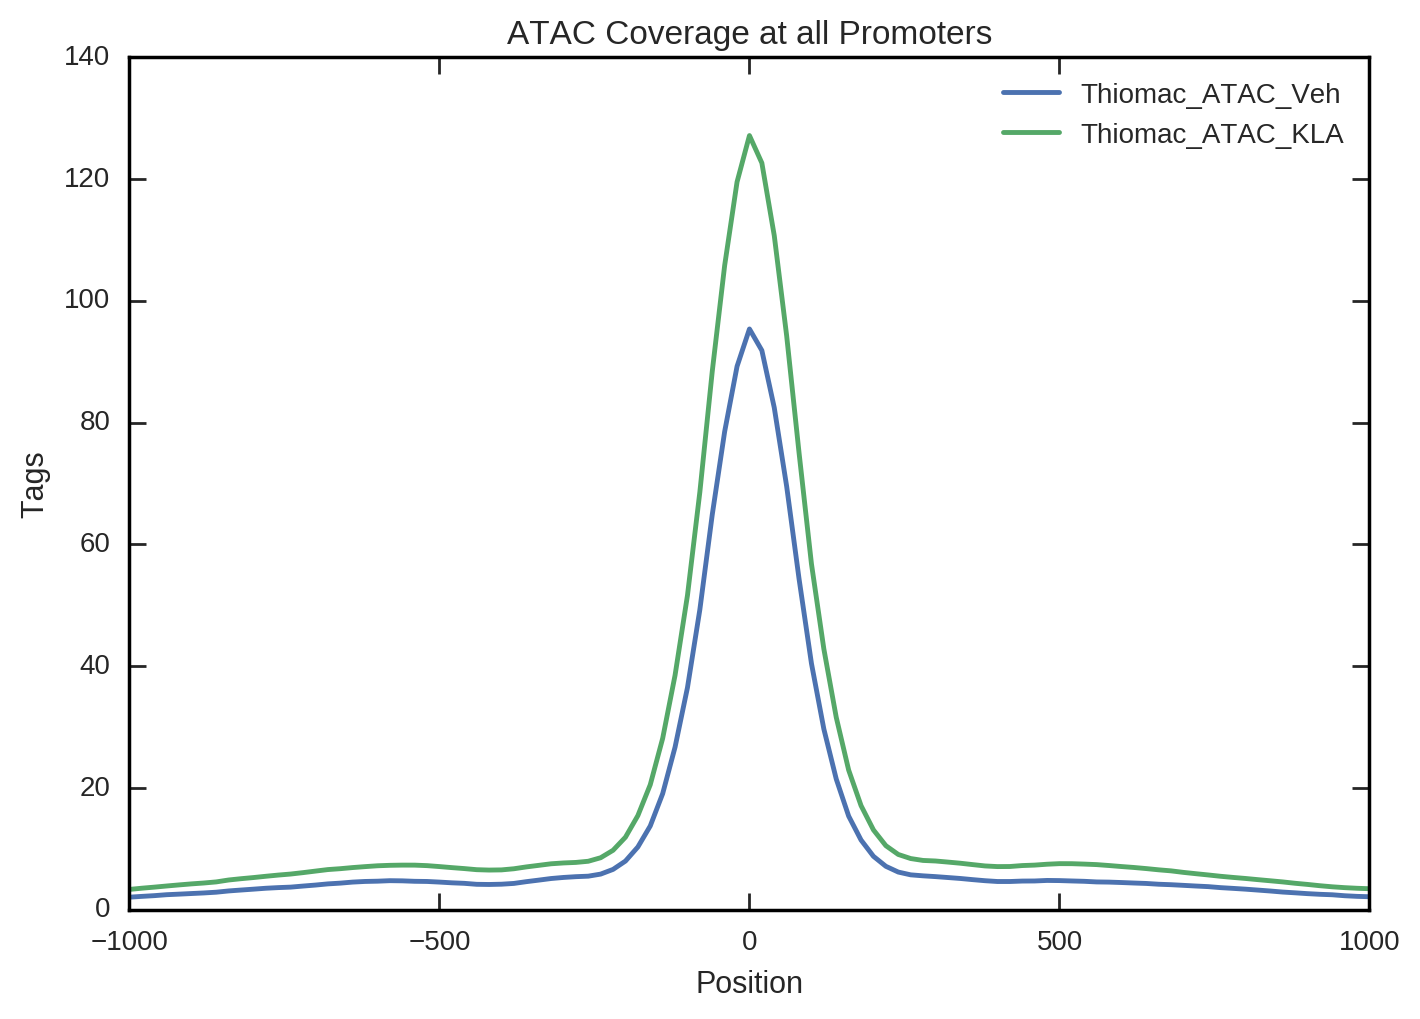

In [531]:
positions = mean_frame['Position']
plt.plot(positions, mean_frame['Thiomac_ATAC_Veh Coverage'])
plt.plot(positions, mean_frame['Thiomac_ATAC_KLA Coverage'])
plt.legend(['Thiomac_ATAC_Veh','Thiomac_ATAC_KLA'])
plt.title('ATAC Coverage at all Promoters')
plt.xlabel('Position')
plt.ylabel('Tags')

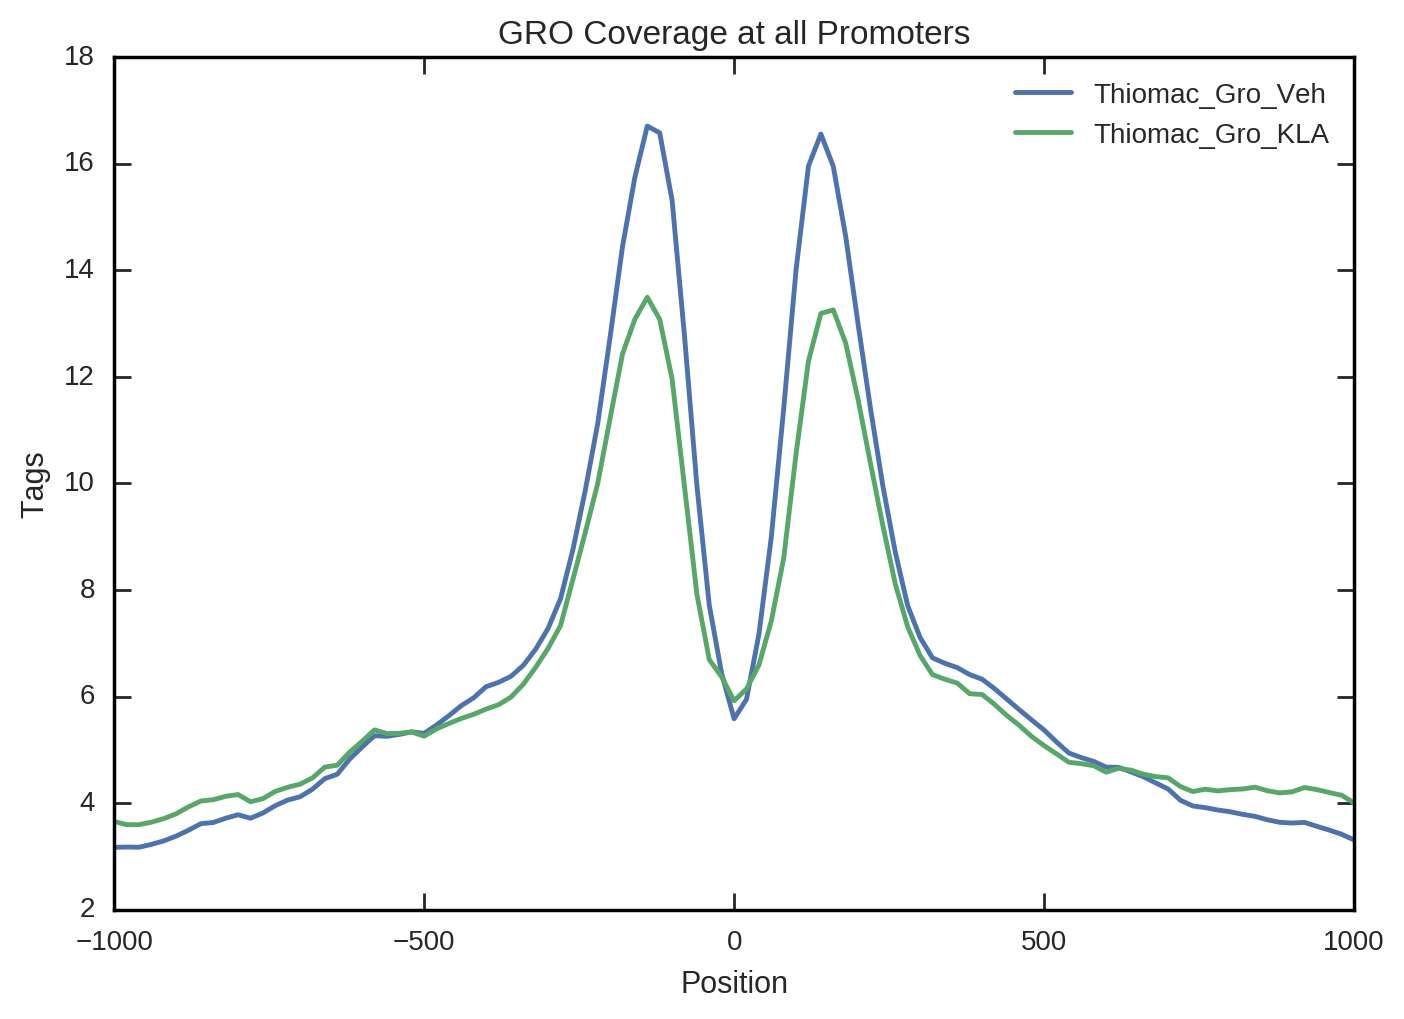

In [532]:
positions = mean_frame['Position']
plt.plot(positions, mean_frame['Thiomac_Gro_Veh Coverage'])
plt.plot(positions, mean_frame['Thiomac_Gro_KLA Coverage'])
plt.legend(['Thiomac_Gro_Veh','Thiomac_Gro_KLA'])
plt.title('GRO Coverage at all Promoters')
plt.xlabel('Position')
plt.ylabel('Tags')

### Enhancer Signatures at Induced Promoters

In [533]:
frame =pd.read_csv('upregulated_hist.tsv',sep='\t')
columns = frame.columns.values
columns = ['Position'] + [x.split('/')[-1] for x in columns[1:]]
frame.columns = columns
condition_samples_dict = {}
for col in columns[1:]:
    if 'Coverage' in col:
        sample = col.split(' ')[0]
        tokens = sample.split('_')
        condition = '_'.join(tokens[1:4]).split('-')[0]
        if not condition in condition_samples_dict:
            condition_samples_dict[condition] = set([sample])
        else:
            condition_samples_dict[condition].add(sample)
mean_frame = frame[['Position']]
for condition in sorted(condition_samples_dict.keys()):
    samples = sorted(condition_samples_dict[condition])
    coverage_cols = [x + ' Coverage' for x in samples]
    sense_cols = [x + ' + Tags' for x in samples]
    antisense_cols = [x + ' - Tags' for x in samples]
    
    mean_frame[condition + ' Coverage'] = np.mean(frame[coverage_cols], axis = 1)
    mean_frame[condition + ' + Tags'] = np.mean(frame[sense_cols], axis = 1)
    mean_frame[condition + ' - Tags'] = np.mean(frame[antisense_cols], axis = 1)





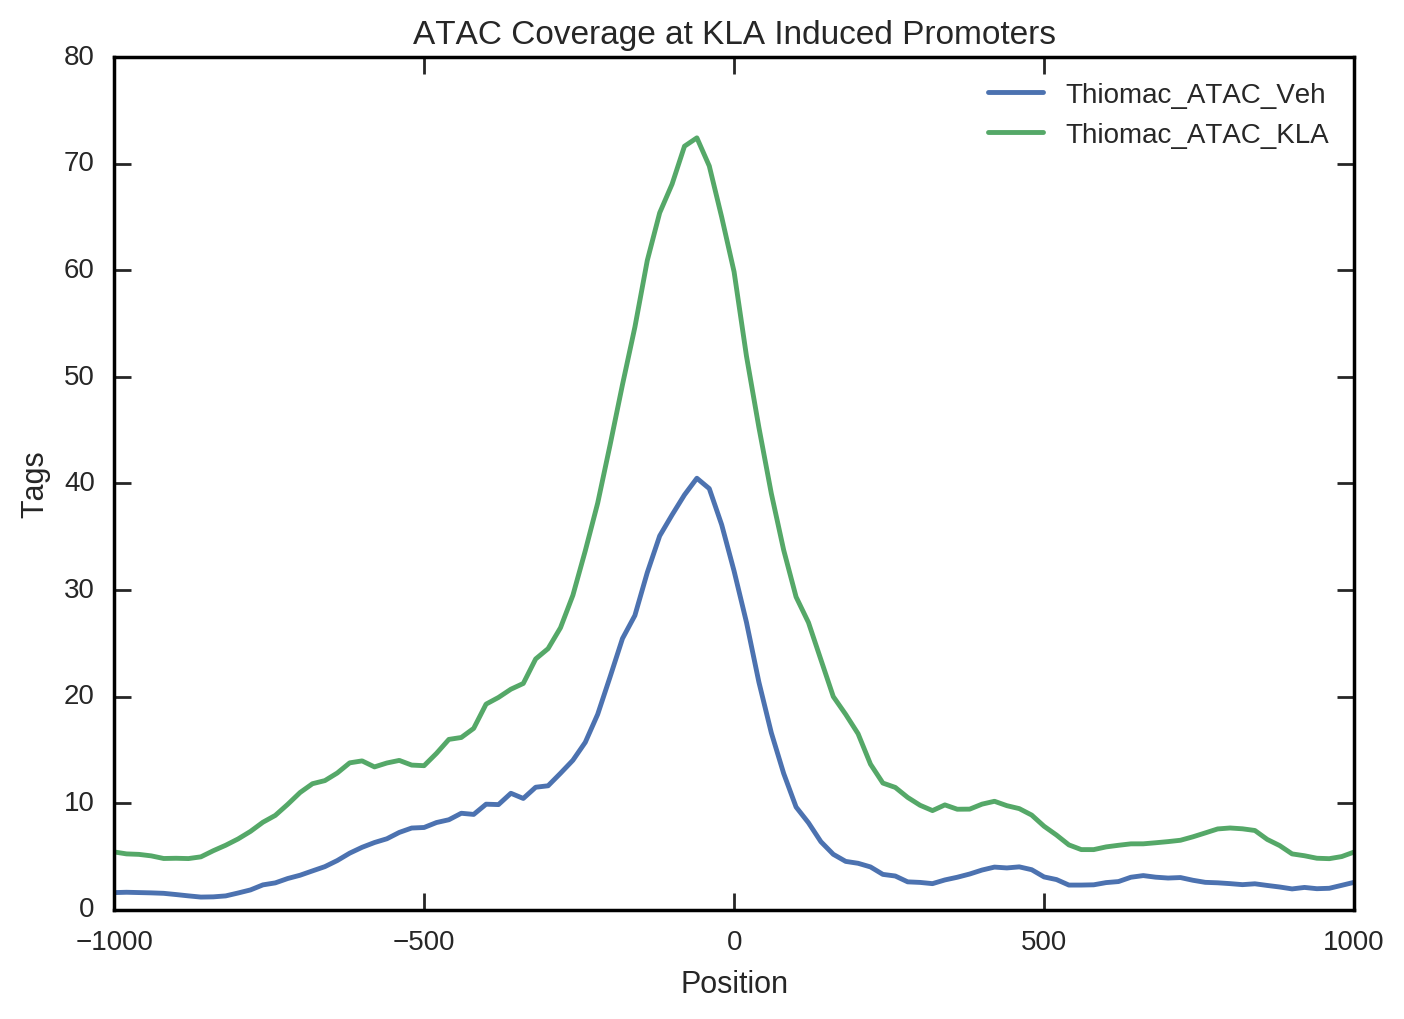

In [534]:

positions = mean_frame['Position']
plt.plot(positions, mean_frame['Thiomac_ATAC_Veh Coverage'])
plt.plot(positions, mean_frame['Thiomac_ATAC_KLA Coverage'])
plt.legend(['Thiomac_ATAC_Veh','Thiomac_ATAC_KLA'])
plt.title('ATAC Coverage at KLA Induced Promoters')
plt.xlabel('Position')
plt.ylabel('Tags')

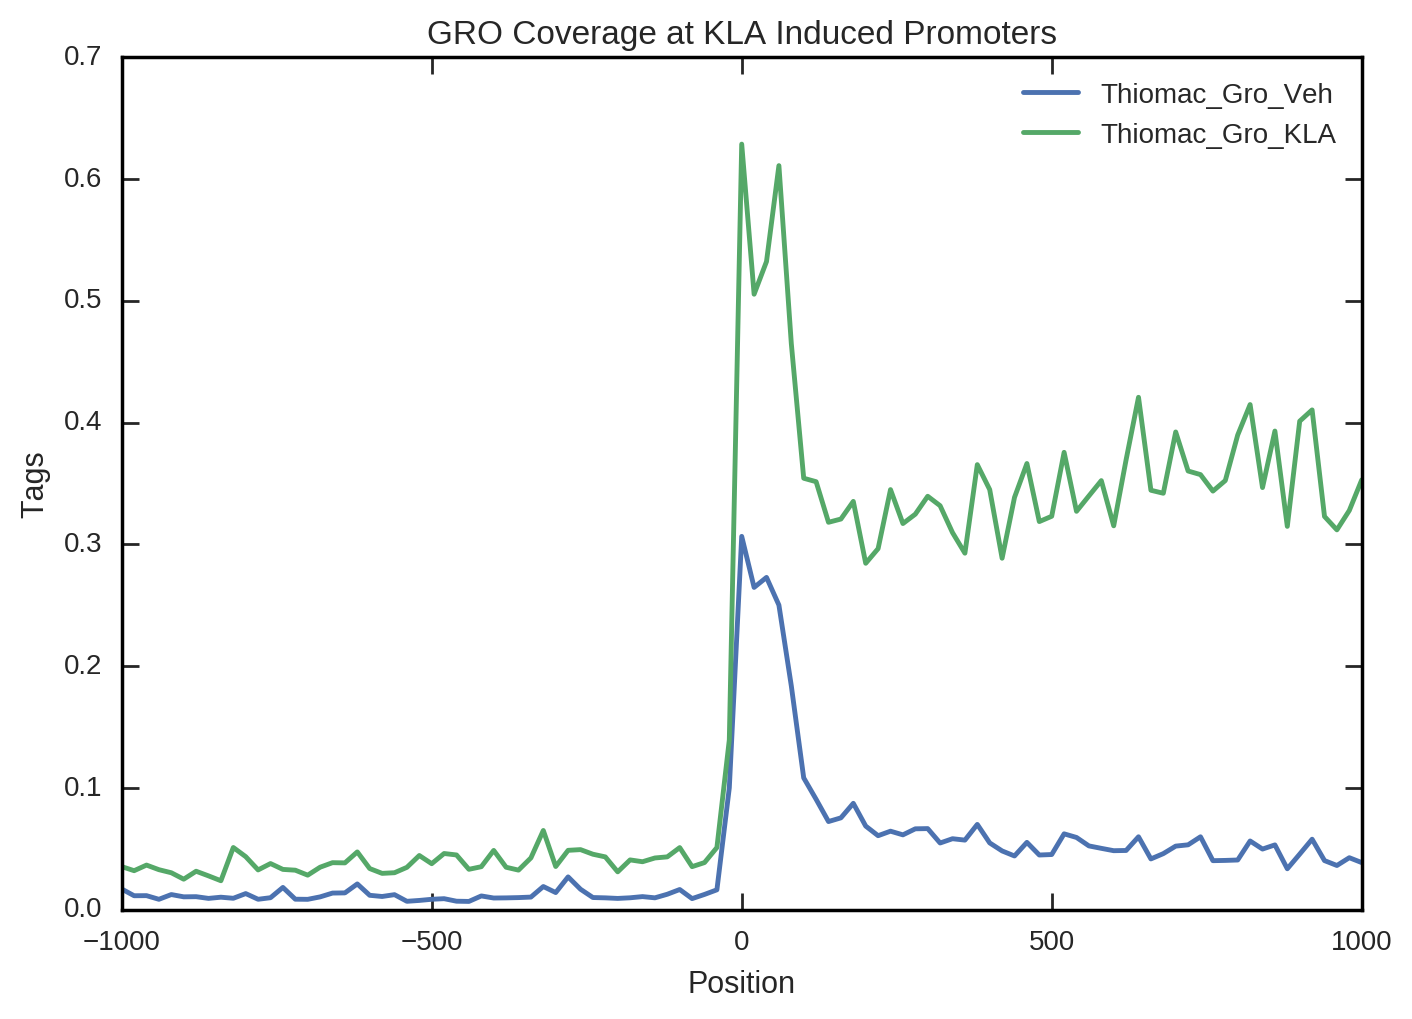

In [535]:
positions = mean_frame['Position']
plt.plot(positions, mean_frame['Thiomac_Gro_Veh + Tags'])
plt.plot(positions, mean_frame['Thiomac_Gro_KLA + Tags'])
plt.legend(['Thiomac_Gro_Veh','Thiomac_Gro_KLA'])
plt.title('GRO Coverage at KLA Induced Promoters')
plt.xlabel('Position')
plt.ylabel('Tags')

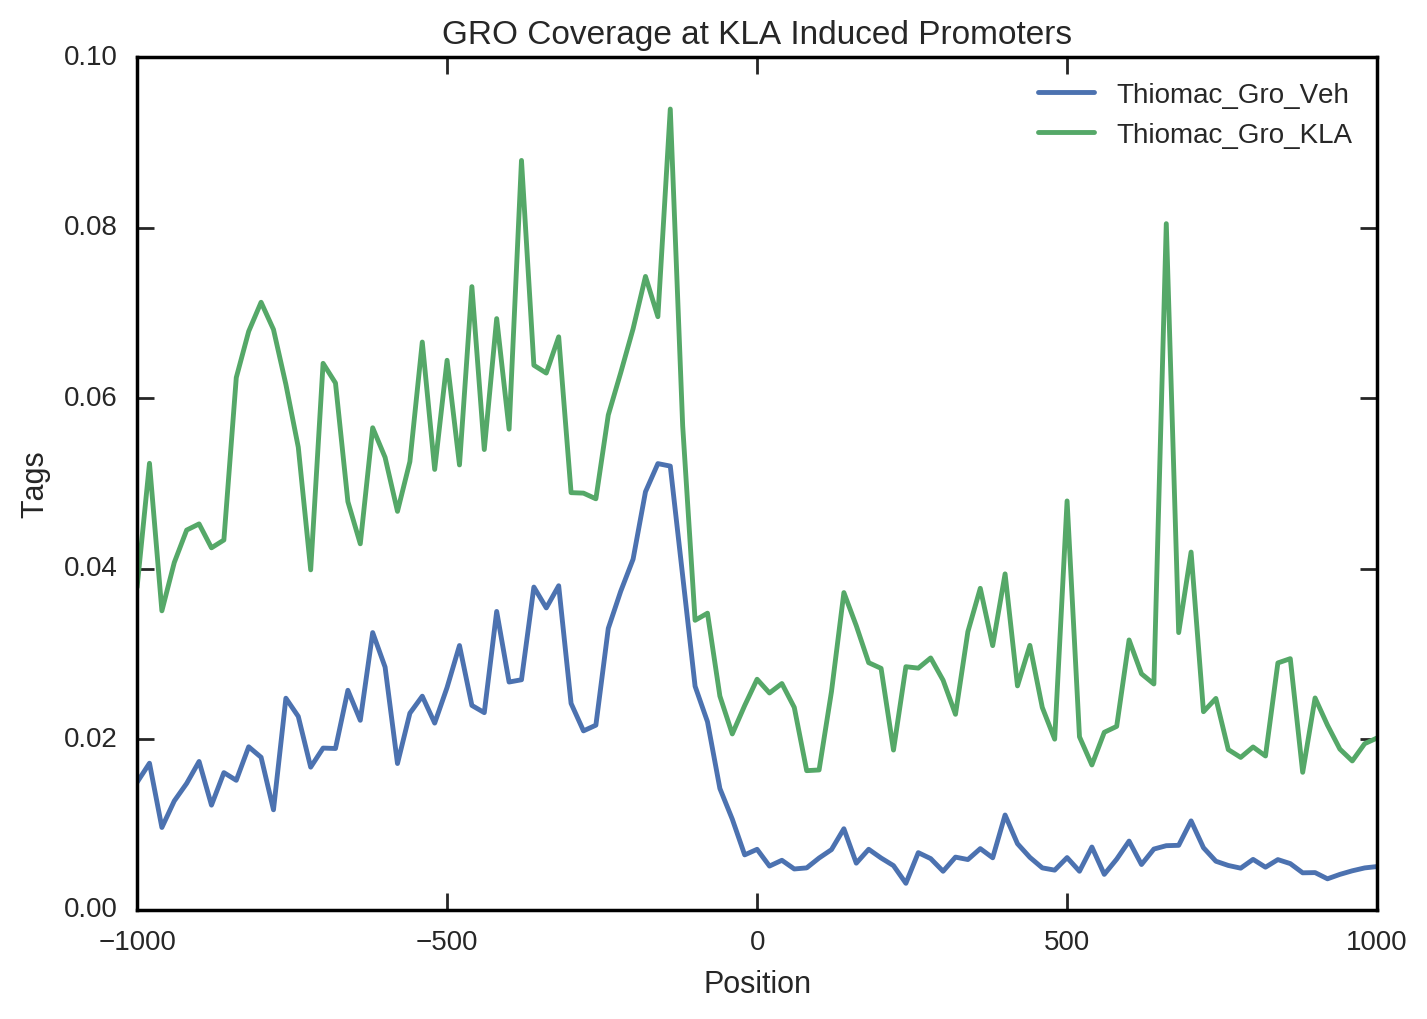

In [536]:
positions = mean_frame['Position']
plt.plot(positions, mean_frame['Thiomac_Gro_Veh - Tags'])
plt.plot(positions, mean_frame['Thiomac_Gro_KLA - Tags'])
plt.legend(['Thiomac_Gro_Veh','Thiomac_Gro_KLA'])
plt.title('GRO Coverage at KLA Induced Promoters')
plt.xlabel('Position')
plt.ylabel('Tags')

In [537]:
upregulated_frame = pd.read_csv('upregulated_annotated_peaks.tsv', sep='\t')
upregulated_frame.index = upregulated_frame.ix[:,0].values
upregulated_frame = upregulated_frame.ix[:,19:]
columns = upregulated_frame.columns.values
columns = [x.split('/')[-1].split(' ')[0] for x in columns]
upregulated_frame.columns = columns
condition_samples_dict = {}
for col in columns[1:]:
    sample = col.split(' ')[0]
    tokens = sample.split('_')
    condition = '_'.join(tokens[1:4]).split('-')[0]
    if not condition in condition_samples_dict:
        condition_samples_dict[condition] = set([sample])
    else:
        condition_samples_dict[condition].add(sample)
mean_upregulated_frame = upregulated_frame[[]]
for condition in sorted(condition_samples_dict.keys()):
    samples = sorted(condition_samples_dict[condition])
    mean_upregulated_frame[condition] = np.mean(upregulated_frame[samples], axis = 1)



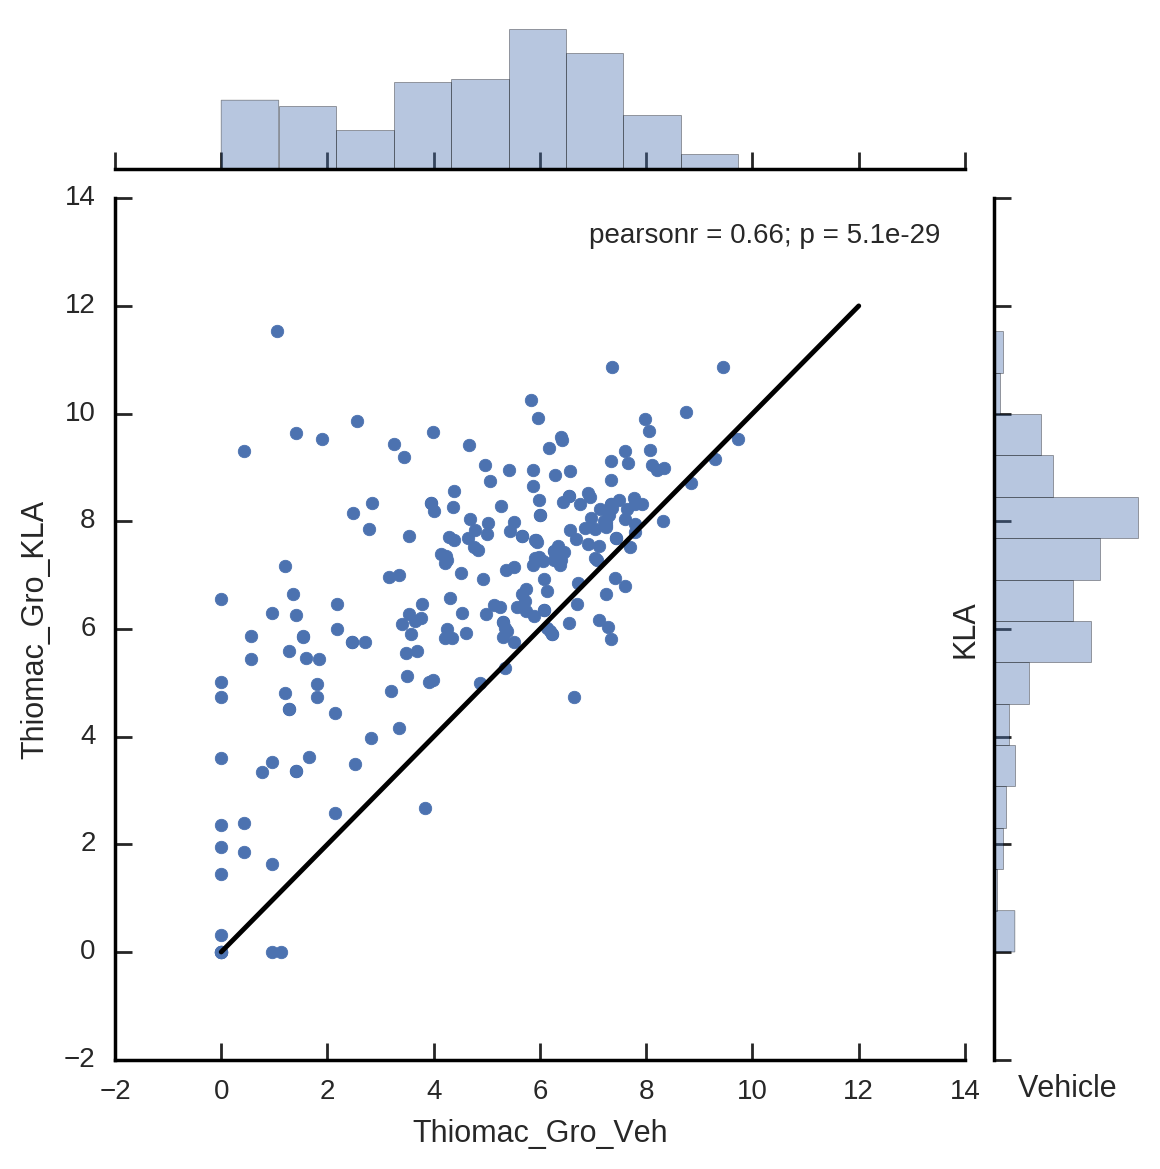

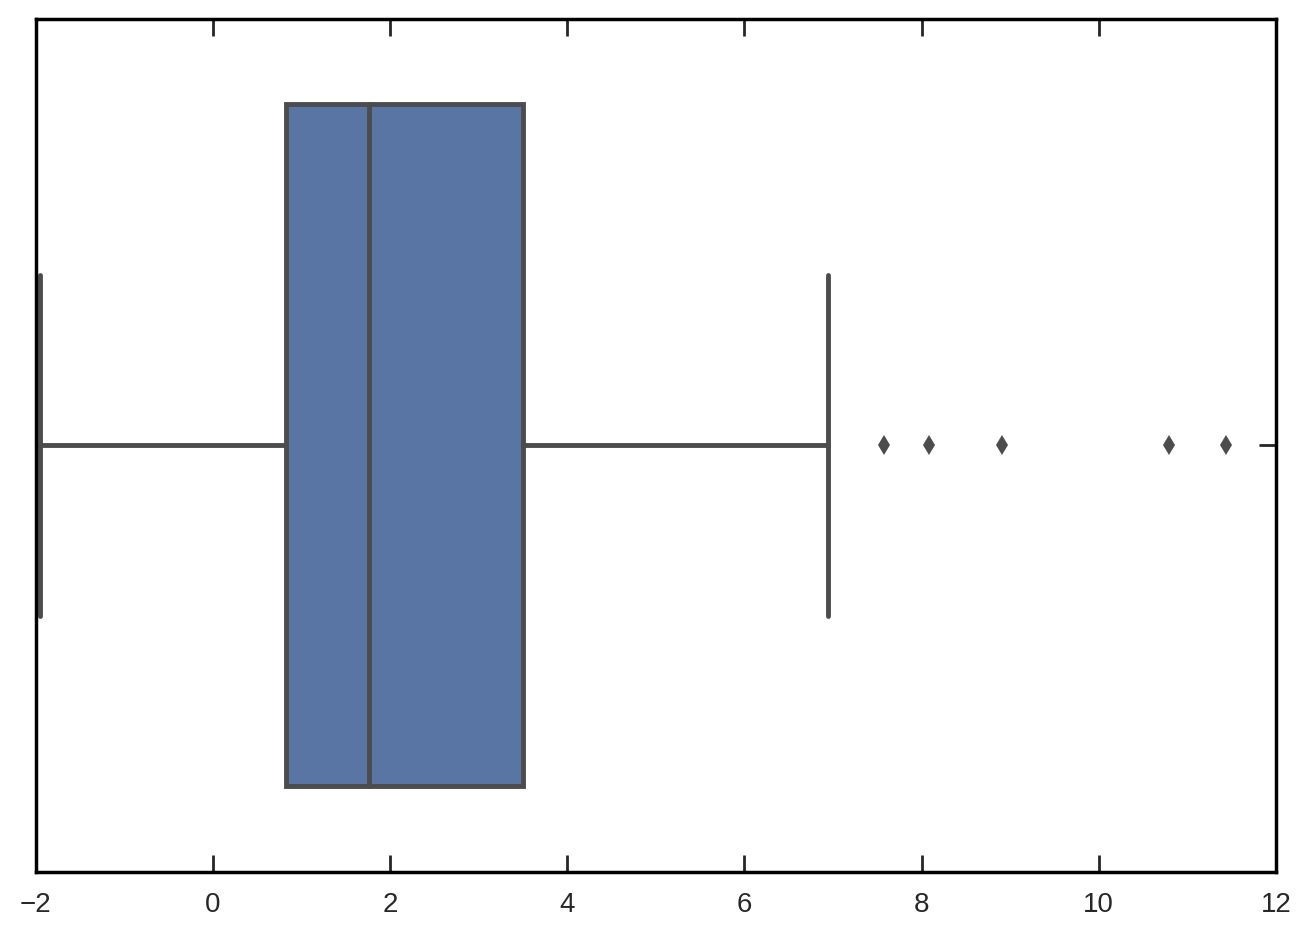

In [559]:
sns.set_style('ticks',{'axes.edgecolor': 'black',
                       'xtick.direction': 'in',
                       'ytick.direction': 'in', 
                         })
cg = sns.jointplot(np.log2(mean_upregulated_frame['Thiomac_Gro_Veh']+1), 
                   np.log2(mean_upregulated_frame['Thiomac_Gro_KLA'] + 1), kind= 'scatter')
cg.ax_joint.plot([0,12], [0,12], c='black')
plt.xlabel('Vehicle')
plt.ylabel('KLA')
plt.show()
sns.boxplot(np.log2(mean_upregulated_frame['Thiomac_Gro_KLA']/ mean_upregulated_frame['Thiomac_Gro_Veh']))

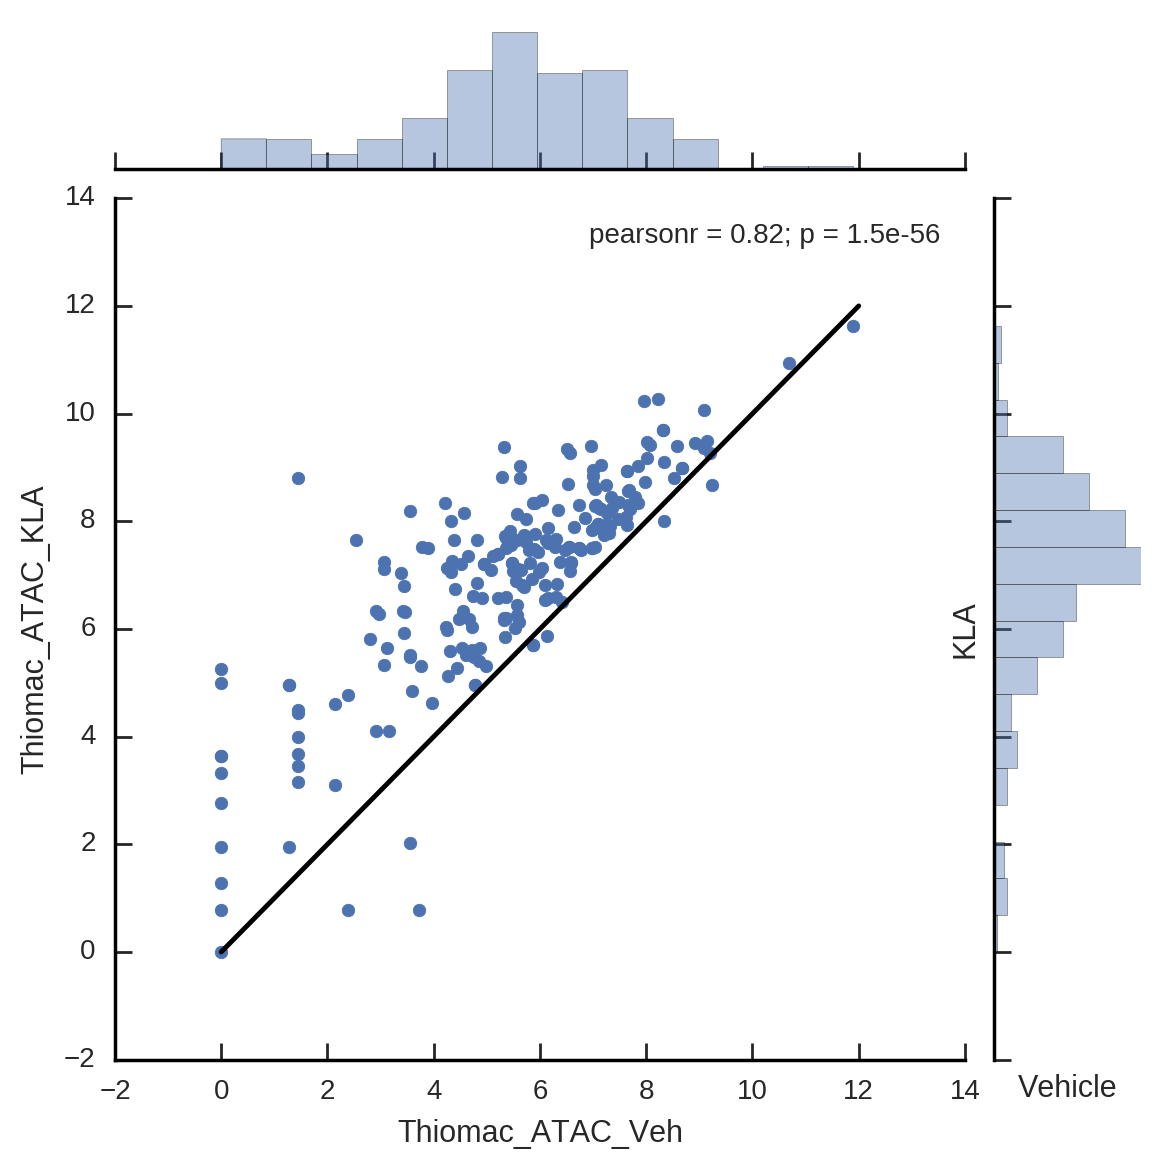

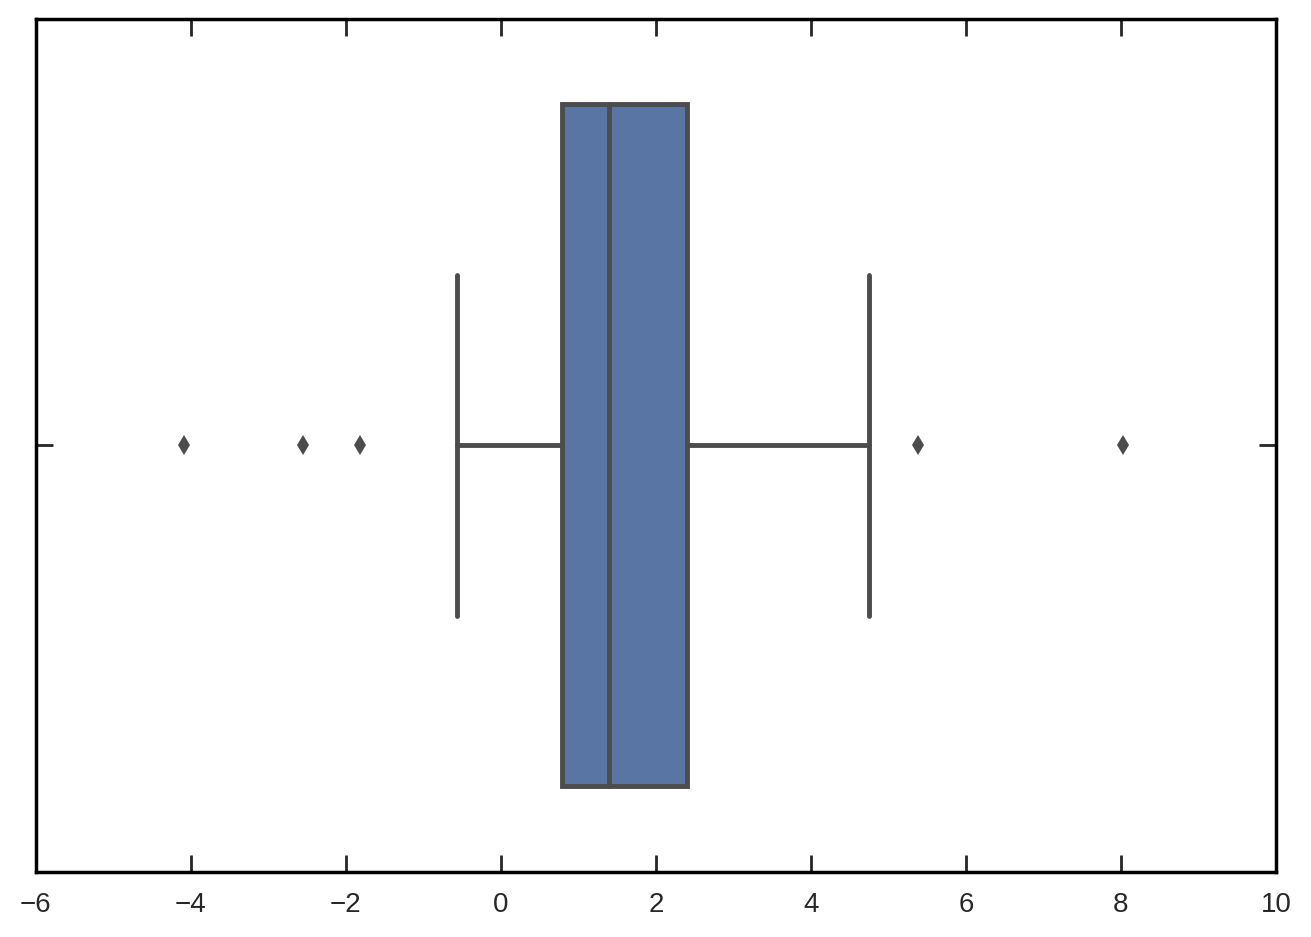

In [558]:
cg = sns.jointplot(np.log2(mean_upregulated_frame['Thiomac_ATAC_Veh'] + 1), 
                   np.log2(mean_upregulated_frame['Thiomac_ATAC_KLA'] + 1), 
                   kind='scatter')
cg.ax_joint.plot([0,12], [0,12], c='black')
plt.xlabel('Vehicle')
plt.ylabel('KLA')
plt.show()
sns.boxplot(np.log2(mean_upregulated_frame['Thiomac_ATAC_KLA']/ mean_upregulated_frame['Thiomac_ATAC_Veh']))

## Predict KLA Responsive Genes  (Classification)

In [577]:
# get genes and refseqs associated with up-regulated genes
up_genes = diffExpression_frame[(diffExpression_frame['Thiomac_Veh vs. Thiomac_KLA adj. p-value'] < 0.05)
                    &(diffExpression_frame['Thiomac_Veh vs. Thiomac_KLA Log2 Fold Change'] >= 1)]['gene'].values
down_genes = diffExpression_frame[(diffExpression_frame['Thiomac_Veh vs. Thiomac_KLA adj. p-value'] < 0.05)
                    &(diffExpression_frame['Thiomac_Veh vs. Thiomac_KLA Log2 Fold Change'] <= -1)]['gene'].values

up_refseqs = diffExpression_frame[(diffExpression_frame['Thiomac_Veh vs. Thiomac_KLA adj. p-value'] < 0.05)
                    &(diffExpression_frame['Thiomac_Veh vs. Thiomac_KLA Log2 Fold Change'] >= 1)]['refseq'].values
down_refseqs = diffExpression_frame[(diffExpression_frame['Thiomac_Veh vs. Thiomac_KLA adj. p-value'] < 0.05)
                    &(diffExpression_frame['Thiomac_Veh vs. Thiomac_KLA Log2 Fold Change'] <= -1)]['refseq'].values

In [578]:
set(up_genes) - set(annotation_frame['Gene Name'].str.upper())

{'1810011O10RIK', 'IFRD1', 'PTGS2', 'RAB20'}

In [579]:
kla_responsive_refsqs = up_refseqs

In [760]:
train

array([ 1281,  1300,  1313, ..., 10174, 10175, 10176])

In [803]:
# Run classifier with cross-validation and plot ROC curves

### use all promoters that pass through IDR
# idr_refseqs = [gene_refseq_mapping[x] for x in idr_rpkm_mean_frame.index.values]
# features = normed_motif_promoters_frame[normed_motif_promoters_frame.index.isin(idr_refseqs)]
# labels = peak_promoters_frame[peak_promoters_frame.index.isin(idr_refseqs)]['ID'].isin(up_refseqs)

### use all promoters that has an ATAC-seq peak over it
promoter_peakIDs= annotation_frame[annotation_frame['Annotation'].str.contains('promoter').fillna(False)]['ID'].values
kla_responsive_peakIDs = []
for gene in up_genes:
    current_frame = annotation_frame[(annotation_frame['Annotation'].str.contains('promoter')) &
                 (annotation_frame['Gene Name'].str.upper() == gene)]
    if current_frame.shape[0] > 0:
        min_peakID = current_frame[
            current_frame['Distance to TSS'] == current_frame['Distance to TSS'].min(axis=1)]['ID'].values[0]
        kla_responsive_peakIDs.append(min_peakID)

features = normed_motif_frame[normed_motif_frame.index.isin(promoter_peakIDs)]
labels = peak_frame[peak_frame.index.isin(promoter_peakIDs)]['ID'].isin(kla_responsive_peakIDs)

cv = sklearn.cross_validation.StratifiedKFold(labels, n_folds=5)

lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')


mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    print(len(train),len(test))
    probas_ = lr_classifier.fit(features.ix[train,:], labels[train]).predict_proba(features.ix[test,:])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(labels[test], probas_[:, 1])
    mean_tpr += scipy.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

8141 2036
8141 2036
8142 2035
8142 2035
8142 2035


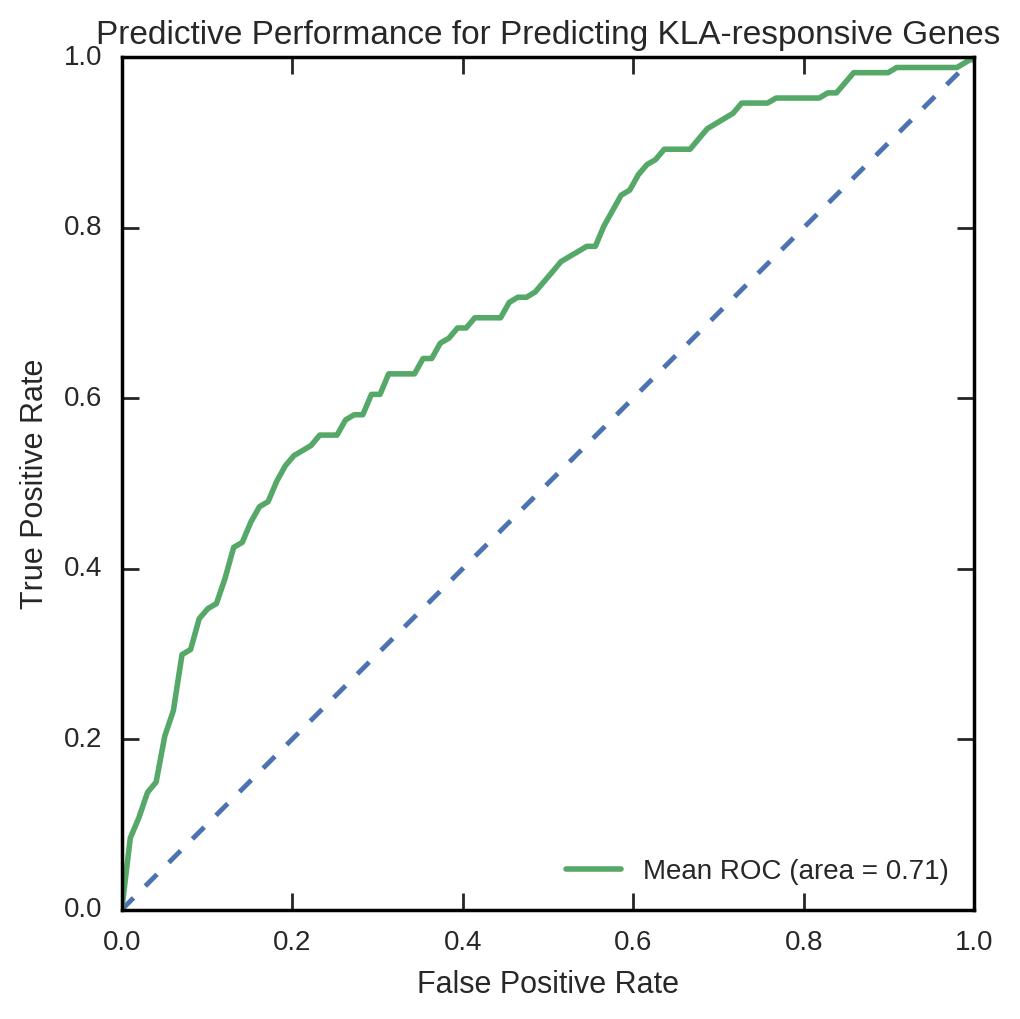

In [804]:
plt.plot([0, 1], [0, 1], '--')

plt.plot(mean_fpr, mean_tpr,
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Predictive Performance for Predicting KLA-responsive Genes')
plt.legend(loc="lower right")
plt.axes().set_aspect('equal')

plt.show()

fpr_all = mean_fpr
tpr_all = mean_tpr
auc_all = mean_auc

In [790]:
coefficients_frame = pd.DataFrame({'Promoter ATAC':lr_classifier.coef_[0]})
coefficients_frame.index = normed_motif_frame.columns.values

In [791]:
threshold = 2.0

factor_motifs_dict = {}
significant_motifs = set()
for factor in coefficients_frame.columns.values:
    weights = coefficients_frame[factor]
    std = np.std(weights)
    mean = np.mean(weights)
    positive_hits = list(weights[weights >= mean + threshold*std].index.values)
    negative_hits = list(weights[weights <= mean - threshold*std].index.values)
    motif_hits = negative_hits + positive_hits
    
    print(factor, mean-threshold*std, mean+threshold*std)
    for m in motif_hits:
        significant_motifs.add(m)

Promoter ATAC -0.836860308515 0.822708185767


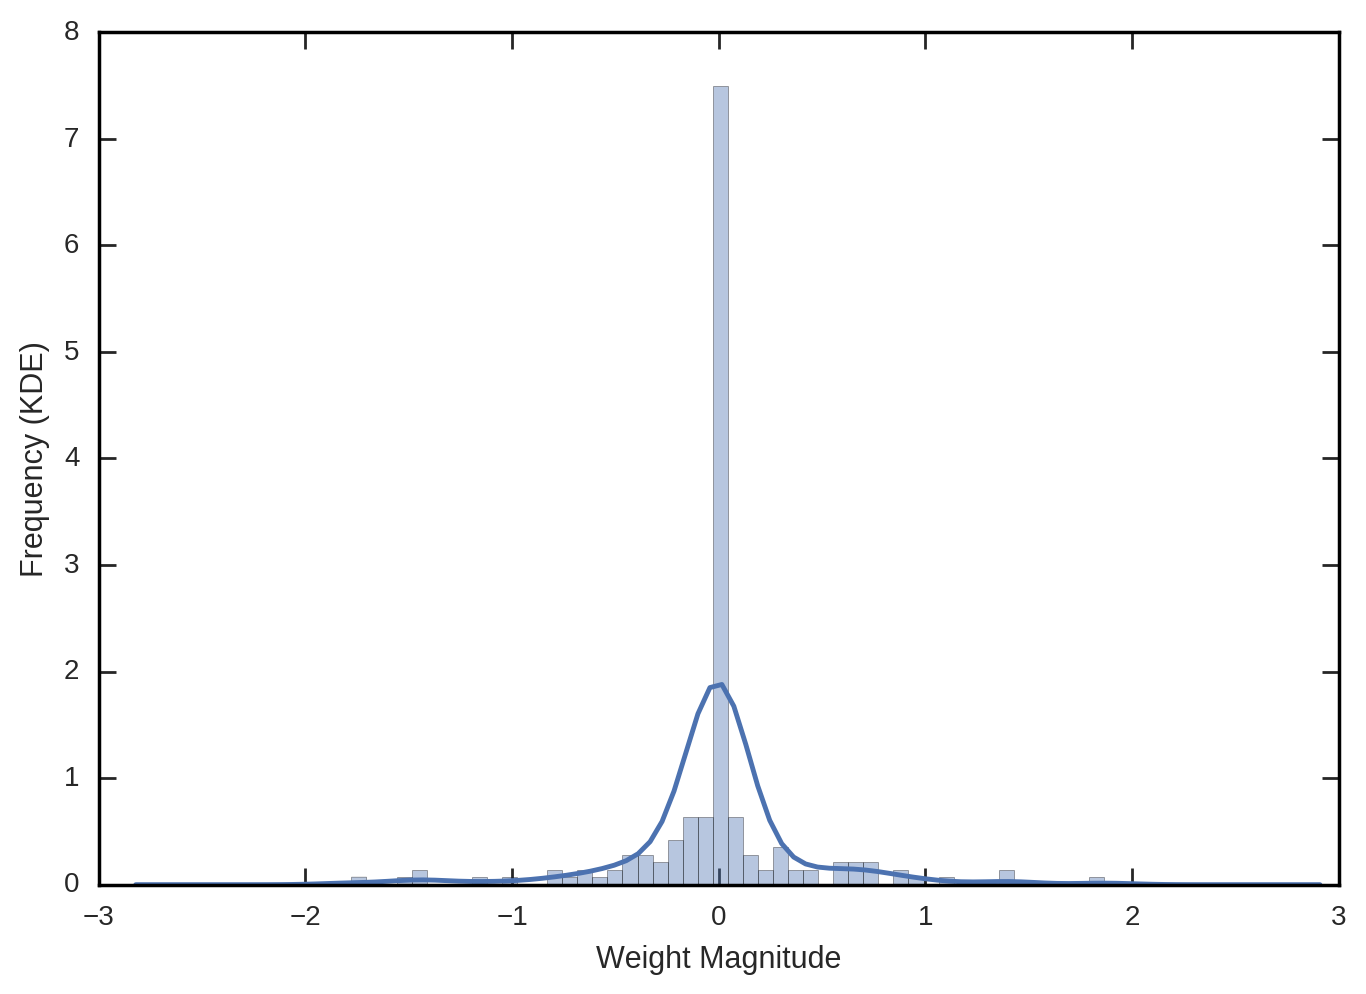

In [818]:
sns.distplot(coefficients_frame.values.flatten())
plt.xlabel('Weight Magnitude')
plt.ylabel('Frequency (KDE)')

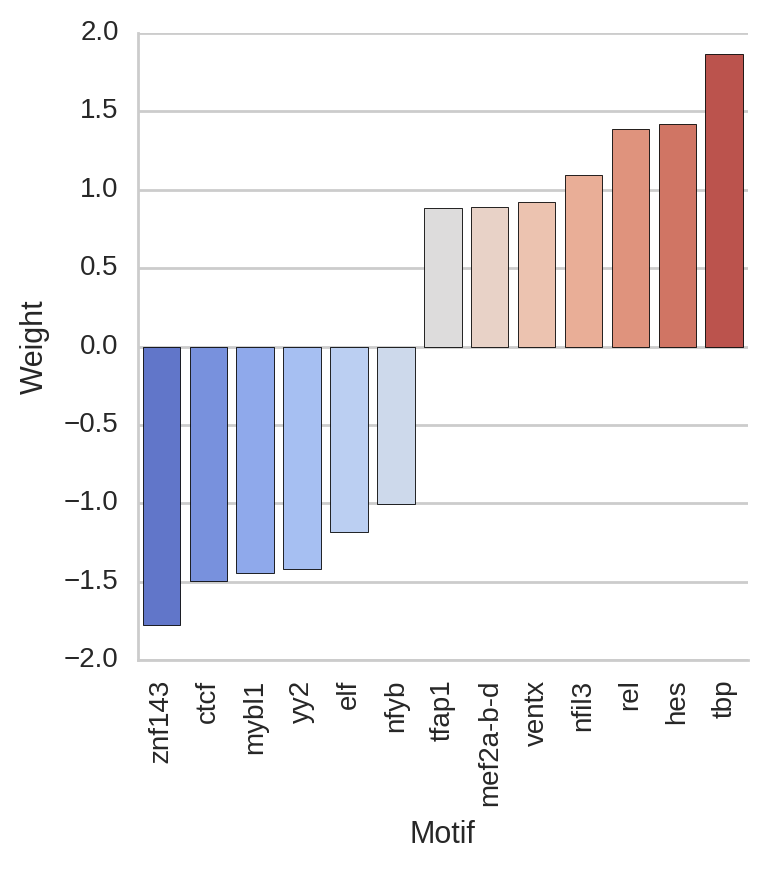

In [817]:
threshold = 3
coeff_std = np.std(coefficients_frame.values.flatten())
coeff_mean = np.mean(coefficients_frame.values.flatten())
data = coefficients_frame[coefficients_frame.index.isin(significant_motifs)]

# fig, ax = plt.subplots(figsize=(10,10))
with sns.axes_style('whitegrid'):
    data['Motif'] = data.index.values
    data.columns = ['Weight', 'Motif']
    data = data.sort('Weight')
    sns.factorplot(data = data, x= 'Motif', y='Weight', size=4, kind='bar', palette='coolwarm')
    plt.xticks(rotation=90)

### predict on Top Motifs and Individual Motifs

In [815]:
# Run classifier with cross-validation and plot ROC curves

### use all promoters that has an ATAC-seq peak over it
features = normed_motif_frame[normed_motif_frame.index.isin(promoter_peakIDs)][[x for x in normed_motif_frame.columns.values if x in significant_motifs]]
labels = peak_frame[peak_frame.index.isin(promoter_peakIDs)]['ID'].isin(kla_responsive_peakIDs)

cv = sklearn.cross_validation.StratifiedKFold(labels, n_folds=5)

lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')


mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    print(len(train),len(test))
    probas_ = lr_classifier.fit(features.ix[train,:], labels[train]).predict_proba(features.ix[test,:])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(labels[test], probas_[:, 1])
    mean_tpr += scipy.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0000000
mean_auc = auc(mean_fpr, mean_tpr)

tpr_significant = mean_tpr
fpr_significant = mean_fpr
auc_significant = mean_auc

8141 2036
8141 2036
8142 2035
8142 2035
8142 2035


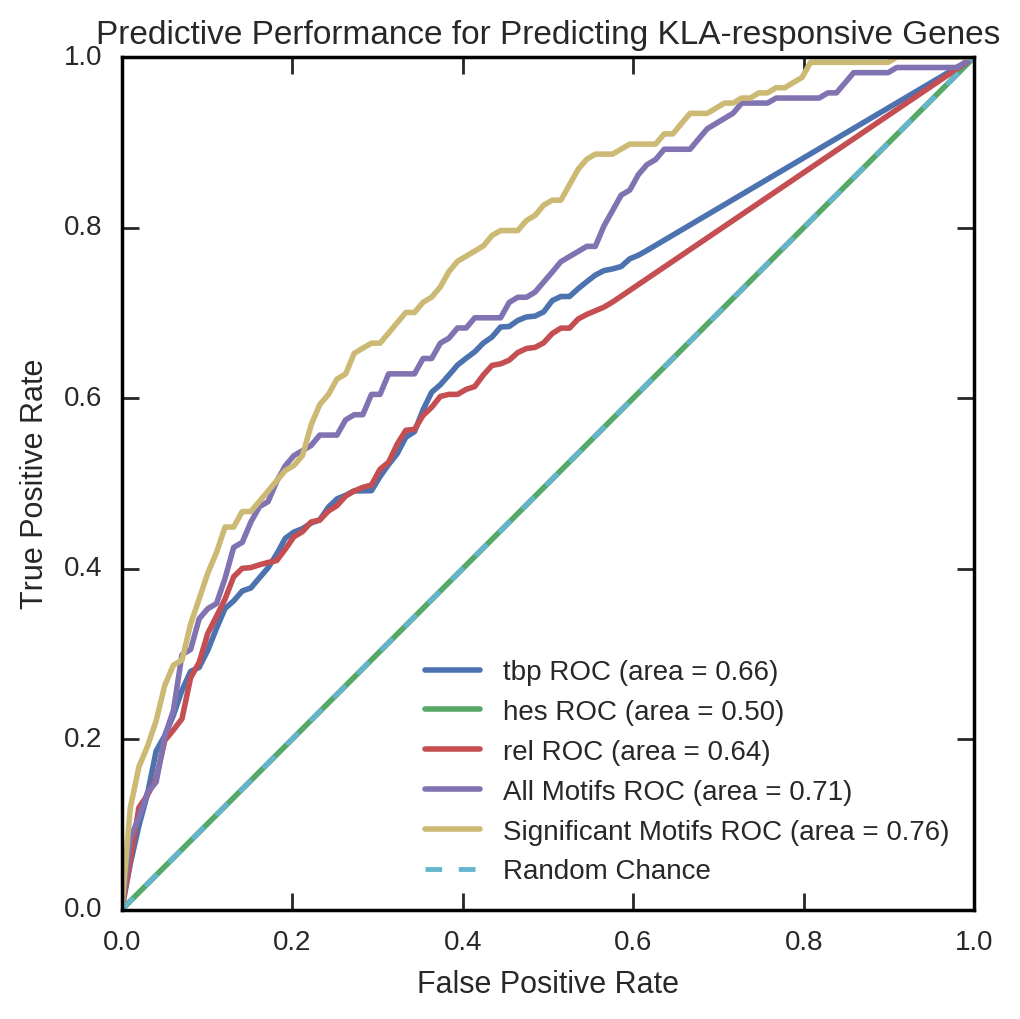

In [816]:
# Run classifier with cross-validation and plot ROC curves
top_motifs = ['tbp', 'hes', 'rel']
for motif in top_motifs:
    ### use all promoters that has an ATAC-seq peak over it
    features = normed_motif_frame[normed_motif_frame.index.isin(promoter_peakIDs)][[x for x in normed_motif_frame.columns.values if x == motif]]
    labels = peak_frame[peak_frame.index.isin(promoter_peakIDs)]['ID'].isin(kla_responsive_peakIDs)

    cv = sklearn.cross_validation.StratifiedKFold(labels, n_folds=5)

    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')


    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    for i, (train, test) in enumerate(cv):
        probas_ = lr_classifier.fit(features.ix[train,:], labels[train]).predict_proba(features.ix[test,:])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(labels[test], probas_[:, 1])
        mean_tpr += scipy.interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
    #     plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    
    plt.plot(mean_fpr, mean_tpr,
         label=motif + ' ROC (area = %0.2f)' % mean_auc, lw=2)

plt.plot(fpr_all, tpr_all,
     label='All Motifs ROC (area = %0.2f)' % auc_all, lw=2)

plt.plot(fpr_significant, tpr_significant,
     label= 'Significant Motifs ROC (area = %0.2f)' % auc_significant, lw=2)

plt.plot([0, 1], [0, 1], '--', label = 'Random Chance')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Predictive Performance for Predicting KLA-responsive Genes')
plt.legend(loc="lower right")
plt.axes().set_aspect('equal')

### Cluster Promoters According to Motifs

In [788]:
data = data= normed_motif_frame[normed_motif_frame.index.isin(promoter_peakIDs)]\
    [[ x for x in normed_motif_frame.columns if x in positive_hits]]

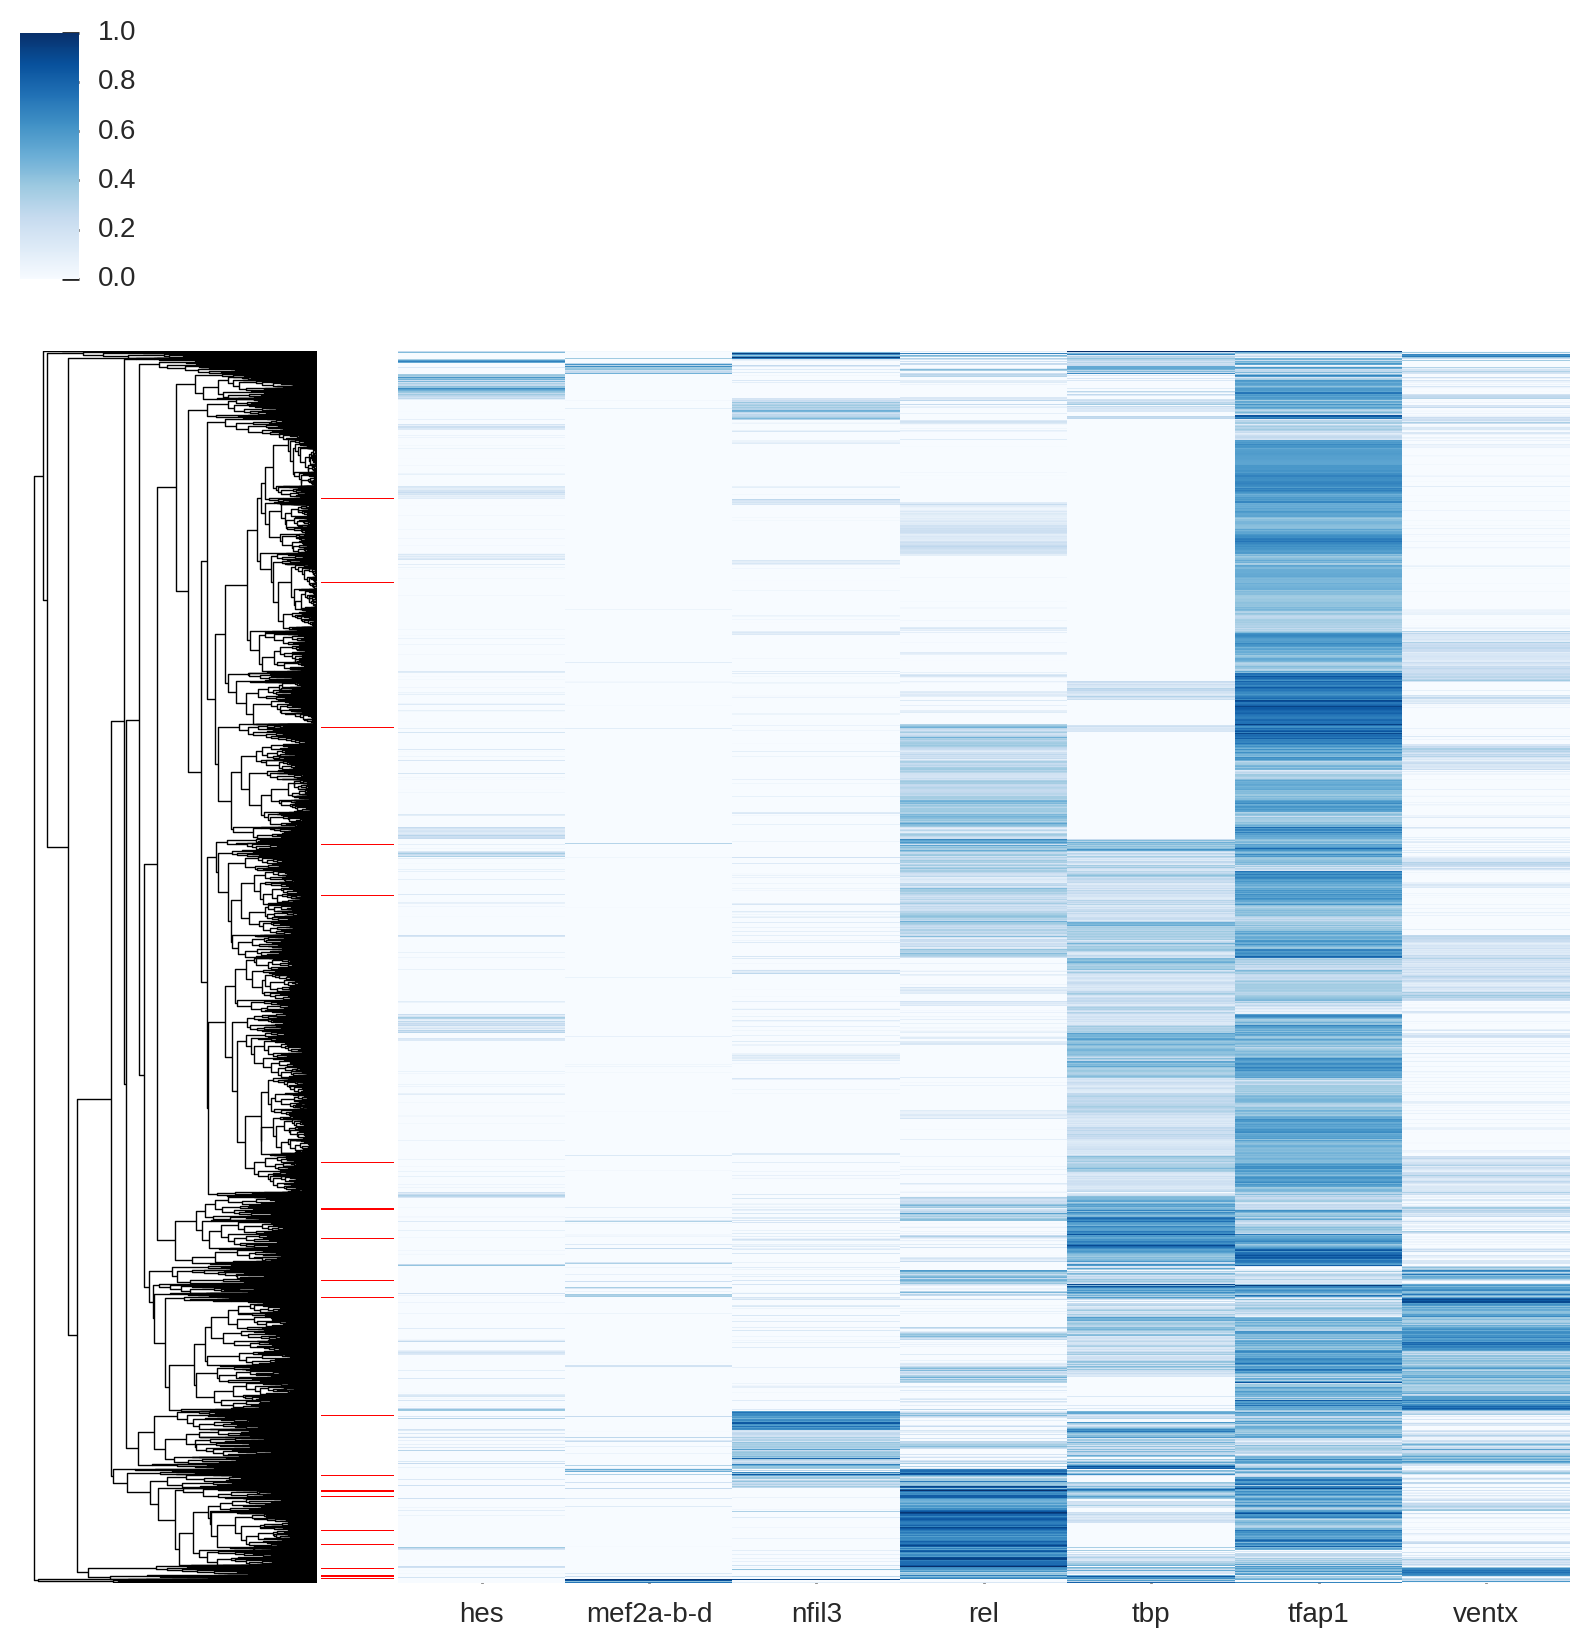

In [789]:
colors = ['Red' if x else 'white' for x in peak_frame[peak_frame.index.isin(promoter_peakIDs)]['ID'].isin(kla_responsive_peakIDs)]
sns.clustermap(data= data,
               row_colors = colors, 
               yticklabels=False,
              col_cluster = False,
              cmap='Blues')


## Regress Against Fold Change

In [649]:
current_frame = idr_rpkm_mean_frame
idr_refseqs = [gene_refseq_mapping[x] for x in idr_rpkm_mean_frame.index.values]

fold_change = np.log2((current_frame['C57Bl6_Thiomac_KLA-1h'] + 1)/(current_frame['C57Bl6_Thiomac_Veh'] + 1))

In [650]:
refseq_foldChange_dict = dict(zip(idr_refseqs, fold_change))

In [656]:
features = normed_motif_promoters_frame[normed_motif_promoters_frame.index.isin(idr_refseqs)]



Residual sum of squares: 0.32


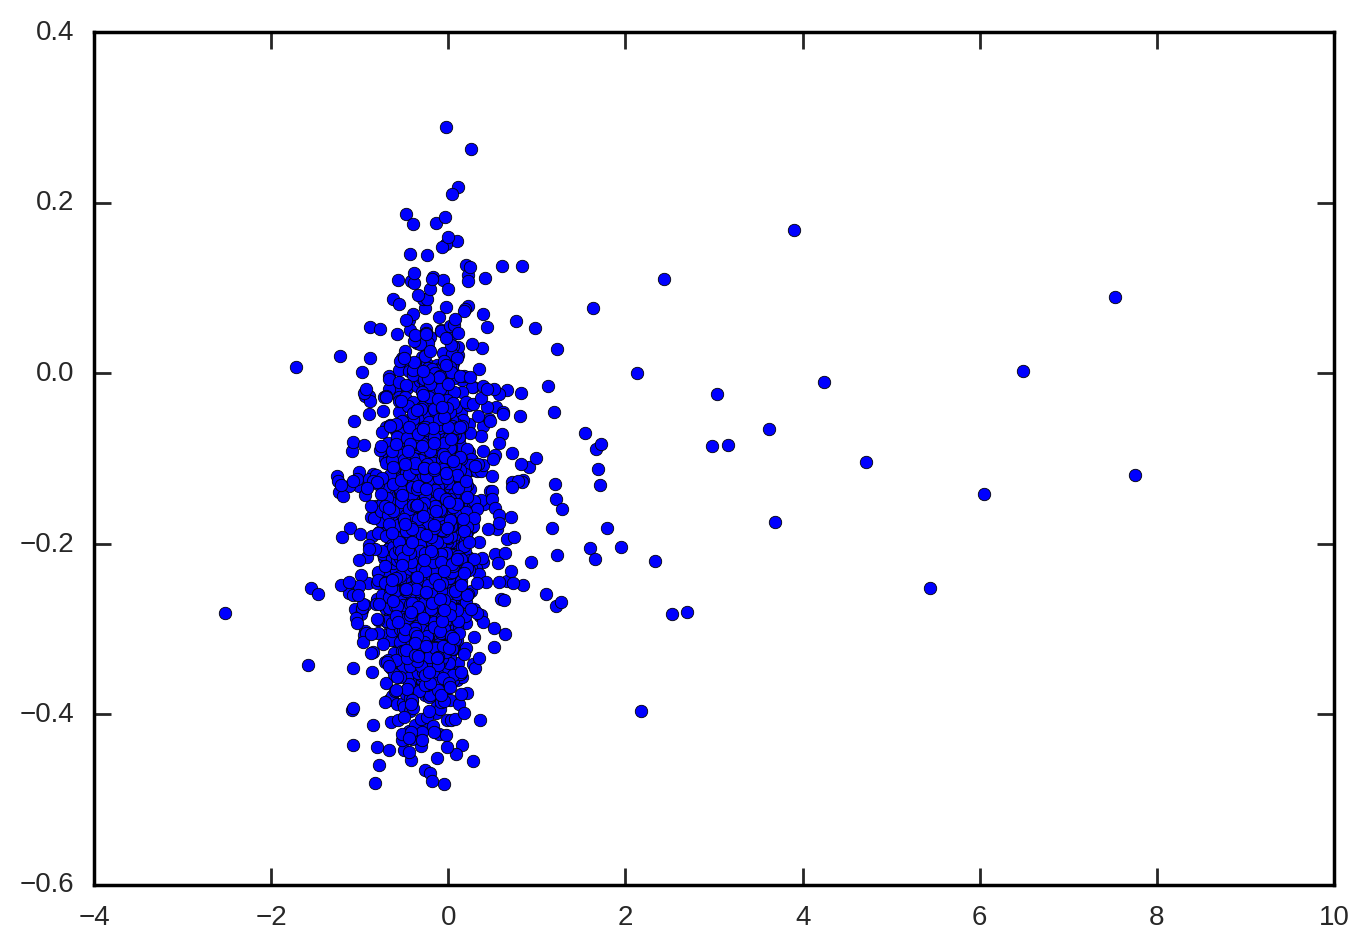

In [734]:

features = normed_motif_promoters_frame[normed_motif_promoters_frame.index.isin(idr_refseqs)]
labels = np.array([refseq_foldChange_dict[x] for x in features.index.values])


training_features, test_features, training_labels, test_labels = sklearn.cross_validation.train_test_split(
    features, labels, test_size=0.2)


# Fit regression model

regressor = sklearn.linear_model.LinearRegression()

regressor.fit(training_features, training_labels)

# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((regressor.predict(test_features) - test_labels) ** 2))
# Explained variance score: 1 is perfect prediction

plt.scatter(test_labels, regressor.predict(test_features))
